# Financial ratios per la previsione di bancarotta  
  
In questa sezione vengono applicati i metodi precedentemente descritti ad un caso pratico. In particolare, vengono fatte analisi dati in seguito al bilanciamento del dataset in questione. L'obiettivo è quello di analizzare i diversi risultati ottenuti al variare della strategia di ricampionamento utilizzata e confrontarli. Il tema di questo data set sono i financial fatios per la previsione dello stato di bancarotta. Questo è un tema molto importante che viene trattato con particolare attenzione all'interno degli isituti finanziari. Il fine principale è quello di prendere decisioni appropriate per finanziare prestiti che non abbiano un impatto negativo sugli istituti stessi.  I financial ratios in letteratura sono conosciuti come fattori importanti che influenzano la bancarotta. Essi possono essere classificati in 7 categorie: solvency, profitability, cash flow ratios, capital structure ratios, turnover ratios, growth e others. Oltre a quanto già detto un altro fine di questo lavoro è quello di testare algoritmi e tecniche per capire quali features hanno un maggior peso rispetto alle altre nella predizione della bancarotta.

In [1]:
#%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from FisherDA import MultipleFisherDiscriminantAnalysis as MDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
from linear_r2 import generate_square, HyperplaneR2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks 

## Descrizione del dataset nel dettaglio

Questo dataset presenta dati che sono stati raccolti dal Taiwain Economic Journal tra il 1999 e il 2009. Lo stato di bancarotta viene definito in base alla regolamentazione del mercato azionario taiwanese.  
Il dataset presenta 6819 righe e 96 colonne così suddivise:  
- stato attuale: colonna 1, 0=no bancarotta, 1=si bancarotta   
- solvency: colonne 14, 32-37, 40-43, 54, 67, 84-85, 95  
- capital structure ratios: colonne 38-39, 76-79, 91-93  
- profitability: colonne 1-10, 19, 23, 68-70, 6, 89-90, 94  
- turnover ratios: colonne 44-50, 71-75, 88  
- cahs flow ratios: colonne 13, 80-83  
- growth: colonne 24-31  
- others: colonne 11-12, 15-18, 20-22, 51-53, 87  

In [2]:
frs = pd.read_csv('C:/Users/filip/Desktop/python-mia/datasets/data.csv',header=0)
#display(frs)

0    6599
1     220
Name: Bankrupt?, dtype: int64


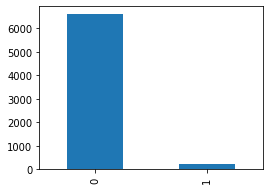

In [3]:
frs['Bankrupt?'].value_counts().plot.bar(figsize=(4,3))
print(frs['Bankrupt?'].value_counts())

Il barplot mostra che le classi sono altamente sbilanciate e questo potrebbe generare diversi problemi nell'applicazione di metodi predittivi.

## Random oversampling & random undersampling

Suddivisione training (50%) e test (50%) set per PCA e LDA

In [4]:
X=frs.iloc[:,1:96]
y=frs.iloc[:,0]
random_state = 20210528
test_p = 0.5

indices = np.arange(X.shape[0])
Xtrain, Xtest, ytrain, ytest  = train_test_split(X, y, test_size=test_p, random_state=random_state, shuffle=True,stratify=y)

In [5]:
print(Xtrain.shape)
print(Xtest.shape)

(3409, 95)
(3410, 95)


Il pacchetto train_test_split permette di dividere il dataset iniziale in 2 sottoinsiemi da poter utilizzare separatamente. L'opzione stratify=y permette di dividere i dati in training e test mantenendo al loro interno le proporzioni esatte rispetto al bilanciamento iniziale delle classi. Senza questa opzione si potrebbero generare dei training set pari al 50% dei dati totali ma con al loro interno solo 0 o solo 1. All'interno del training set sbilanciato si va ad effettuare il pareggio delle classi utilizzando il random oversampling, random undersampling, Smote, Adasyn e Tomek's links. Per questa prima parte verranno utilizzate solamente le prime due delle tecniche appena citate.

In [6]:
ros = RandomOverSampler(random_state=random_state)
Xtrain_over, ytrain_over = ros.fit_resample(Xtrain, ytrain)

rus = RandomUnderSampler(random_state=random_state)
Xtrain_under, ytrain_under = rus.fit_resample(Xtrain, ytrain)

In [7]:
info=pd.DataFrame({'train pca-lda':[list(ytrain).count(0),list(ytrain).count(1)],
                  'train over pca-lda':[list(ytrain_over).count(0),list(ytrain_over).count(1)],
                  'train under pca-lda':[list(ytrain_under).count(0),list(ytrain).count(1)],
                  'test pca-lda':[list(ytest).count(0),list(ytest).count(1)]})
display(info)

,train pca-lda,train over pca-lda,train under pca-lda,test pca-lda
0,3299,3299,110,3300
1,110,3299,110,110


Nella seguente tabella sono presenti le dimensioni dei train e test se,t che verranno utilizzati per applicare la pca e la lda, al variare della strategia di ricampionamento utilizzata.

## Principal Component Analysis (PCA)

La PCA è un metodo che viene definito di apprendimento non supervisionato. Non vi è infatti presente alcuna funzione che associa ai samples iniziali un target ma l'obiettivo principale è quello di capire come sono distribuiti i punti nello spazio. La PCA si occupa quindi di dare una rappresentazione dei dati in dimensione bassa, ad esempio in $\mathbb{R}^2$ o $\mathbb{R}^3$, per avere un'idea di come possano essere distribuite le osservazioni del data set.  
A partire dal nostro data set si proiettano i dati lungo le direzioni che massimizzano la varianza e preservano la distibuzione delle distanze. Minimizzare l'errore legato alla proiezione dei dati coincide con minimizzare il seguente funzionale:  
$$J(e_1,...,e_k,\alpha_{11},...,\alpha_{nk})= \sum_{j=1}^{n}\Vert x_j-\sum_{i=1}^{k} \alpha_{ji}e_i \Vert^2$$
    
    
dove $\{e_k\}_{k \geq 1}$ sono gli elementi della base ortonormale del sottospazio in cui voglio proiettare e gli $\{\alpha_{ij}\}_{i,j \geq 1}$ sono le componenti rispetto alla base. Attraverso il calcolo delle derivate ci si riconduce a risolvere il problema agli autovalori:  
$$ S e_m=\lambda_m e_m$$
$$ S=\sum_{i=1}^{k} x_j^\top x_j $$
  
Dove S è la Scatter Matrix ossia la matrice di varianza-covarianza campionaria moltiplicata per n-1 dove n è il numero totale di osservazioni. La soluzione del problema di minimo che massimizza la varianza è data dai primi k più grandi autovalori di S. Vengono quindi definite le PC come le direzioni ortogonali lungo le quali proiettare, ossia i primi k autovettori della matrice S.

Text(0, 0.5, 'cumulative explained variance ratio')

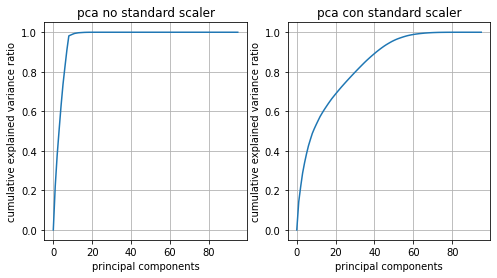

In [8]:
pca=PCA()
pcas=PCA()
scaler=StandardScaler()
scaler.fit(Xtrain)
Xtrain_scaled=scaler.transform(Xtrain)
pca.fit(Xtrain)
pcas.fit(Xtrain_scaled)

fig0, axs0 = plt.subplots(1, 2, figsize=(8, 4))
axs0[0].plot(np.insert(np.cumsum(pca.explained_variance_ratio_),0,0))
axs0[0].set_title('pca no standard scaler')
axs0[0].grid()
axs0[0].set_xlabel('principal components')
axs0[0].set_ylabel('cumulative explained variance ratio')
axs0[1].plot(np.insert(np.cumsum(pcas.explained_variance_ratio_),0,0))
axs0[1].set_title('pca con standard scaler')
axs0[1].grid()
axs0[1].set_xlabel('principal components')
axs0[1].set_ylabel('cumulative explained variance ratio')

I grafici mostrano come la PCA senza standard scaler non possa essere affidabile in termini rapppresentativi. Infatti è poco probabile che si spieghi il 90% della varianza con solo 7 features su un totale di 95. Le statistiche base dei dati evidenziano inoltre che esistono valori con range di intervalli completamente diversi e sproporzionati. Infine, non essendo note le unità di misura delle colonne, non è possibile capire quanto gli intervalli di valori siano dello stesso ordine di grandezza. Questo potrebbe implicare che le colonne con maggior variabilità vadano ad inglobare anche quelle con più bassa variabilità.

In [9]:
#frs.describe()

In [10]:
pca09=PCA(0.9)
pcas09=PCA(0.9)
pca09.fit(Xtrain)
pcas09.fit(Xtrain_scaled)
df09=pd.DataFrame({'n° PC':[pca09.n_components_,pcas09.n_components_],
                'var spiegata':[pca.explained_variance_ratio_.sum(),pcas09.explained_variance_ratio_.sum()]},
               index=['explvar_no_scaled=0.9','explvar_scaled=0.9'])
display(df09)

,n° PC,var spiegata
explvar_no_scaled=0.9,7,1.00000
explvar_scaled=0.9,41,0.90043


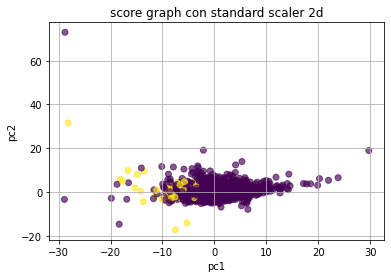

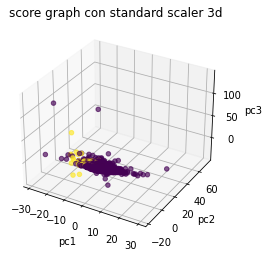

In [11]:
Xtrain_scaled_transf=pcas09.transform(Xtrain_scaled)
plt.figure()
plt.scatter(Xtrain_scaled_transf[:,0],Xtrain_scaled_transf[:,1],c=ytrain.values, alpha=0.65)
plt.title('score graph con standard scaler 2d')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.grid()
plt.show()
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xtrain_scaled_transf[:, 0], Xtrain_scaled_transf[:, 1], 
           Xtrain_scaled_transf[:, 2], c=ytrain.values, alpha=0.65)
plt.title('score graph con standard scaler 3d')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.grid()
plt.show()

Il forte sbilanciamento delle classi non permette una visualizzazione ottimale dei dati. Per rimediare a questo e capire come sono fatti i training set su cui si farà l'addestramento dei metodi, applichiamo la PCA al set di dati con le classi pareggiate.

## PCA random oversampling

Text(0, 0.5, 'cumulative explained variance ratio')

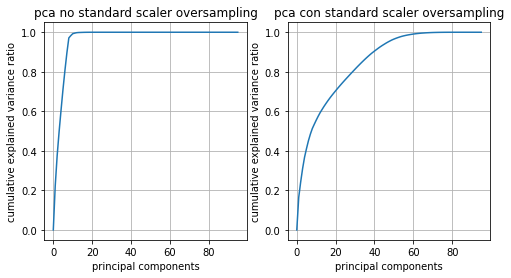

In [12]:
pcao=PCA()
pca_scaledo=PCA()

scalero=StandardScaler()
scalero.fit(Xtrain_over)
Xtrain_over_scaled=scalero.transform(Xtrain_over)

pcao.fit(Xtrain_over)
pca_scaledo.fit(Xtrain_over_scaled)
fig1, axs1 = plt.subplots(1, 2, figsize=(8, 4))
axs1[0].plot(np.insert(np.cumsum(pcao.explained_variance_ratio_),0,0))
axs1[0].set_title('pca no standard scaler oversampling')
axs1[0].grid()
axs1[0].set_xlabel('principal components')
axs1[0].set_ylabel('cumulative explained variance ratio')
axs1[1].plot(np.insert(np.cumsum(pca_scaledo.explained_variance_ratio_),0,0))
axs1[1].set_title('pca con standard scaler oversampling')
axs1[1].grid()
axs1[1].set_xlabel('principal components')
axs1[1].set_ylabel('cumulative explained variance ratio')

In [13]:
explvar1=0.9
pca_var1_over=PCA(explvar1)
pca_var1_over.fit(Xtrain_over)
pca_var1_scaled_over=PCA(explvar1)
pca_var1_scaled_over.fit(Xtrain_over_scaled)
dfo=pd.DataFrame({'n° PC':[pca_var1_scaled_over.n_components_,pca_var1_over.n_components_],
                'var spiegata':[pca_var1_scaled_over.explained_variance_ratio_.sum(),pca_var1_over.explained_variance_ratio_.sum()]},
               index=['explvar_scaled_over=0.9','explvar_no_scaled_over=0.9'])
dfo

,n° PC,var spiegata
explvar_scaled_over=0.9,40,0.904692
explvar_no_scaled_over=0.9,8,0.971304


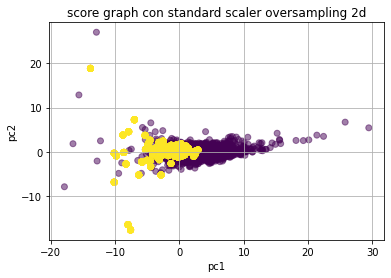

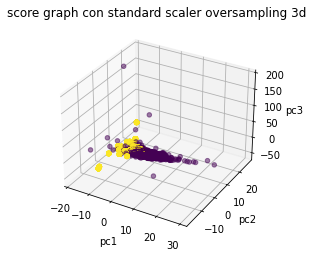

In [14]:
Xtrain_over_scaled_transf=pca_var1_scaled_over.transform(Xtrain_over_scaled)
plt.figure()
plt.scatter(Xtrain_over_scaled_transf[:,0],Xtrain_over_scaled_transf[:,1],c=ytrain_over.values, alpha=0.50)
plt.title('score graph con standard scaler oversampling 2d')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.grid()
plt.show()

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xtrain_over_scaled_transf[:, 0], Xtrain_over_scaled_transf[:, 1], 
           Xtrain_over_scaled_transf[:, 2], c=ytrain_over.values, alpha=0.50)
plt.title('score graph con standard scaler oversampling 3d')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.grid()
plt.show()

## PCA random undersampling

Text(0, 0.5, 'cumulative explained variance ratio')

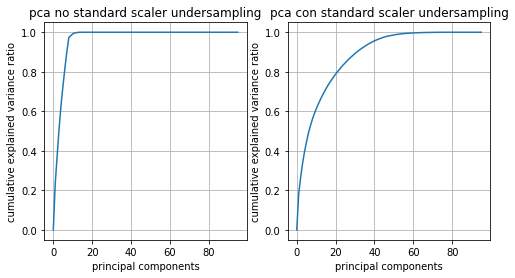

In [15]:
pcau=PCA()
pca_scaledu=PCA()
pcau.fit(Xtrain_under)

scaleru=StandardScaler()
scaleru.fit(Xtrain_under)
Xtrain_under_scaled=scaleru.transform(Xtrain_under)

pca_scaledu.fit(Xtrain_under_scaled)
fig1, axs1 = plt.subplots(1, 2, figsize=(8, 4))
axs1[0].plot(np.insert(np.cumsum(pcau.explained_variance_ratio_),0,0))
axs1[0].set_title('pca no standard scaler undersampling')
axs1[0].grid()
axs1[0].set_xlabel('principal components')
axs1[0].set_ylabel('cumulative explained variance ratio')
axs1[1].plot(np.insert(np.cumsum(pca_scaledu.explained_variance_ratio_),0,0))
axs1[1].set_title('pca con standard scaler undersampling')
axs1[1].grid()
axs1[1].set_xlabel('principal components')
axs1[1].set_ylabel('cumulative explained variance ratio')

In [16]:
pca_var1_under=PCA(explvar1)
pca_var1_under.fit(Xtrain_under)
pca_var1_scaled_under=PCA(explvar1)
pca_var1_scaled_under.fit(Xtrain_under_scaled)
dfu=pd.DataFrame({'n° PC':[pca_var1_scaled_under.n_components_,pca_var1_under.n_components_],
                'var spiegata':[pca_var1_scaled_under.explained_variance_ratio_.sum(),pca_var1_under.explained_variance_ratio_.sum()]},
               index=['explvar_scaled_under=0.9','explvar_no_scaled_under=0.9'])
dfu

,n° PC,var spiegata
explvar_scaled_under=0.9,31,0.900813
explvar_no_scaled_under=0.9,7,0.902652


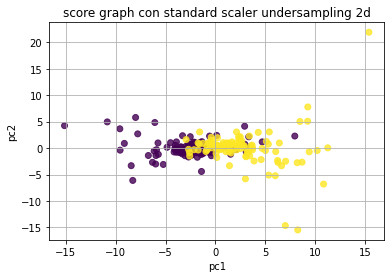

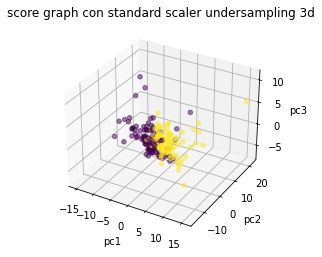

In [17]:
pca_var1_under=PCA(0.9)
scaler=StandardScaler()
scaler.fit(Xtrain_under)
Xtrain_under_scaled=scaler.transform(Xtrain_under)
pca_var1_under.fit(Xtrain_under_scaled)
Xtrain_under_scaled_transf=pca_var1_under.transform(Xtrain_under_scaled)
plt.figure()
plt.scatter(Xtrain_under_scaled_transf[:,0],Xtrain_under_scaled_transf[:,1],c=ytrain_under.values, alpha=0.80)
plt.title('score graph con standard scaler undersampling 2d')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.grid()
plt.show()

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xtrain_under_scaled_transf[:, 0], Xtrain_under_scaled_transf[:, 1], 
           Xtrain_under_scaled_transf[:, 2], c=ytrain_under.values, alpha=0.50)
plt.title('score graph con standard scaler undersampling 3d')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.grid()
plt.show()

Sia col random oversampling che col random undersampling si ottengono migliori visualizzazioni. Sebbene la distribuzione del set di dati sia stata alterata, la PCA evidenzia che nel caso del random undersampling le proiezioni lungo le prime tre PC permettono una migliore separazione dei dati rispetto al random oversampling.

## Linear Discriminant Analysis (LDA) random oversampling

La LDA è un metodo di apprendimento supervisionato con l'obiettivo di stimare la probabilità di appartenenza ad una certa classe. Il principio su cui si basa la LDA è il teorema di Bayes che può essere riscritto nel seguente modo:  
$$P(Y=k|X=x)=\frac{P(X=x|Y=k) P(Y=K)}{P(X=x)}=\frac{\Pi_k f_k(x)}{\sum_{l=1}^{k} \Pi_l f_l(x)}$$  
dove $\Pi_k=$ densità marginale della classe k, $f_k(x)=$densità di x nella classe k. La classificazione dei punti viene effettuata in base alla densità della classe k più alta che i punti sottendono. Sebbene la LDA possa essere fatta a prescindere dalla distribuzione che seguono i punti, sotto le ipotesi che i dati abbiano distribuzione normale omoschedastica ($\sigma_k=\sigma,\, \forall k \in Y$)  si ha che $P_k(x)$ può essere approssimato con $\delta_k(x)$ detto discriminant score, infatti vale:
$$P(Y=k|X=x)=\frac{e^{\delta_k(x)}}{\sum_{l=1}^{k} e^{\delta_l(x)}}$$
$$\delta_k(x)=x \frac{\mu_k}{\sigma^2} - \frac{\mu_k^2}{2\sigma^2} + \log(\Pi_k)=a_kx+b_k$$
dove $\mu_k$ è la media riferita alla distribuzione normale della classe k. Infine, siccome La LDA classifica i punti in base al centroide più vicino e lo span dei centroidi è uno spazio vettoriale di dimensione pari al numero di classi meno uno, è possibile visualizzare le classi predette ad ogni osservazione in uno spazio di dimensione al massimo del numero di classi meno uno. Questo permette di dare un contributo grafico alla visualizzazione delle performance della LDA.

In [18]:
# test normalità dati
k2,p=stats.normaltest(X)
#p

Quanto appena fatto è il test sulla normalità dei dati. Il pacchetto stats di scipy restituisce due valori associati al data set in questione. Il primo è k2 e contiene statistiche eseguite sulle osservazioni a disposizione. Il secondo più importante è un array contenente tanti pvalue quanti sono gli attributi del data set. Per ogni attributo viene eseguito un test d'ipotesi dove l'ipotesi nulla è che i dati siano distribuiti normalmente. Osservando p otteniamo tutti valori minori di $\alpha$=0.05 e di conseguenza rifiutiamo l'ipotesi nulla. Segue che i dati non sono distribuiti normalmente e non possono essere fatte le approssimazioni precedentemente descritte. Decidiamo comunque di applicare la LDA come algoritmo predittivo. 

,acc lda no pca over,acc lda pca over
train over,0.898909,0.873143
test,0.870088,0.548387


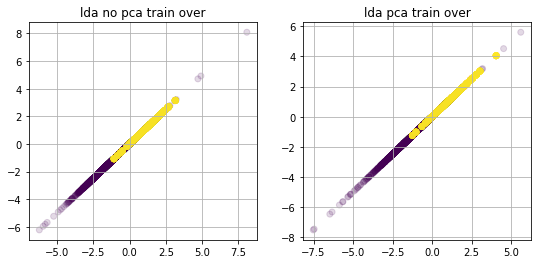

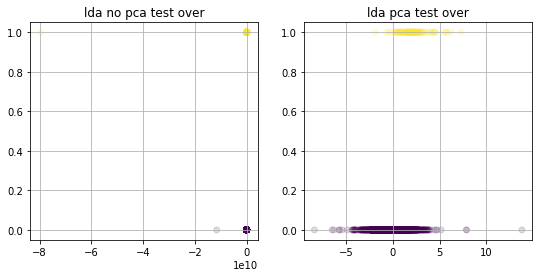

In [19]:
lda_over=LDA()
lda_pca_over=LDA()
lda_over.fit(Xtrain_over,ytrain_over)
lda_pca_over.fit(Xtrain_over_scaled_transf,ytrain_over)

scaler_over=StandardScaler()
scaler_over.fit(Xtest)
Xtest_scaled=scaler_over.transform(Xtest)

zldatr_over=lda_over.transform(Xtrain_over)
zlda_pcatr_over=lda_pca_over.transform(Xtrain_over_scaled_transf)
zldate_over=lda_over.transform(Xtest)
zlda_pcate_over=lda_pca_over.transform(pca_var1_scaled_over.transform(Xtest_scaled))

df_lda_over= pd.DataFrame({'acc lda no pca over': [lda_over.score(Xtrain_over, ytrain_over), lda_over.score(Xtest, ytest)],
                       'acc lda pca over': [lda_pca_over.score(Xtrain_over_scaled_transf, ytrain_over), 
                                            lda_pca_over.score(pca_var1_scaled_over.transform(Xtest_scaled), ytest)]}, 
                      index=['train over', 'test'])
display(df_lda_over)

fig1, axs1 = plt.subplots(1, 2, figsize=(9, 4))
axs1[0].scatter(zldatr_over.flatten(),zldatr_over.flatten(),c=ytrain_over,alpha=0.15)
axs1[1].scatter(zlda_pcatr_over.flatten(),zlda_pcatr_over.flatten(),c=ytrain_over,alpha=0.15)
axs1[0].set_title('lda no pca train over')
axs1[1].set_title('lda pca train over')
axs1[0].grid()
axs1[1].grid()
fig2, axs2 = plt.subplots(1, 2, figsize=(9, 4))
axs2[0].scatter(zldate_over.flatten(),ytest,c=ytest,alpha=0.15)
axs2[1].scatter(zlda_pcate_over.flatten(),ytest,c=ytest,alpha=0.15)
axs2[0].set_title('lda no pca test over')
axs2[1].set_title('lda pca test over')
axs2[0].grid()
axs2[1].grid()

In [20]:
y_pred_over= lda_over.predict(Xtest)
y_pred_proba_over=lda_over.predict_proba(Xtest)
y_pred_pca_over= lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled))
y_pred_proba_pca_over=lda_pca_over.predict_proba(pca_var1_scaled_over.transform(Xtest_scaled))
y_pred_df_over= pd.DataFrame({'actual class test':ytest,
                          'pred class no pca': y_pred_over, 
                          'p(class 0) - % no pca': np.round(y_pred_proba_over[:, 0] * 100, decimals=2), 
                          'p(class 1) - % no pca': np.round(y_pred_proba_over[:, 1] * 100, decimals=2),
                          'pred class si pca': y_pred_pca_over, 
                          'p(class 0) - % (si pca)': np.round(y_pred_proba_pca_over[:, 0] * 100, decimals=2), 
                          'p(class 1) - % (si pca)': np.round(y_pred_proba_pca_over[:, 1] * 100, decimals=2)})
infoldao=pd.DataFrame({'actual class':[list(y_pred_df_over["actual class test"]).count(0),list(y_pred_df_over["actual class test"]).count(1)],
                     'pred class no pca over':[list(y_pred_df_over["pred class no pca"]).count(0),list(y_pred_df_over["pred class no pca"]).count(1)],
                     'pred class pca over':[list(y_pred_df_over["pred class si pca"]).count(0),list(y_pred_df_over["pred class si pca"]).count(1)]})
display(infoldao)

,actual class,pred class no pca over,pred class pca over
0,3300,2909,1768
1,110,501,1642


Nella tabella osserviamo che 391 osservazioni sono state predette non correttamente senza PCA, mentre con la PCA il numero sale a 1532. Le predizioni sbagliate sono riferite a casi di non bancarotta che in realtà lo sono. Tuttavia, da questa tabella si può osservare solo il numero finale di casi sbagliati quindi non si può affermare a priori che tra i 110 "1" non ci sia qualche "0" che è stato predetto come "1". Per capire questo si utilizza la confusion matrix e l'f1 score. Ciò che si può affermare con certezza è che la LDA nel caso del random oversampling tende a predirre casi di non bancarotta come bancarotta visto che predice più "1" del dovuto.

In [21]:
acc_traino = lda_over.score(Xtrain_over, ytrain_over)
prec_traino = precision_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')
rec_traino = recall_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')
f1_traino = f1_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')

acc_train_pcao = lda_pca_over.score(pca_var1_scaled_over.transform(Xtrain_over_scaled), ytrain_over)
prec_train_pcao = precision_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')
rec_train_pcao = recall_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')
f1_train_pcao = f1_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')

acc_testo = lda_over.score(Xtest, ytest)
prec_testo = precision_score(ytest,y_pred_over, average='weighted')
rec_testo = recall_score(ytest,y_pred_over, average='weighted')
f1_testo = f1_score(ytest,y_pred_over, average='weighted')

acc_test_pcao = lda_pca_over.score(pca_var1_scaled_over.transform(Xtest_scaled), ytest)
prec_test_pcao = precision_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')
rec_test_pcao = recall_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')
f1_test_pcao = f1_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')

df_perfo = pd.DataFrame({'acc': [acc_traino, acc_testo], 
                        'prec': [prec_traino, prec_testo], 
                        'rec': [rec_traino, rec_testo],
                        'f1': [f1_traino, f1_testo]
                       },
                      index=['train lda no pca over', 'test lda no pca over'])
df_perfop = pd.DataFrame({'acc': [acc_train_pcao, acc_test_pcao], 
                        'prec': [prec_train_pcao, prec_test_pcao], 
                        'rec': [rec_train_pcao, rec_test_pcao],
                        'f1': [f1_train_pcao, f1_test_pcao]
                       },
                      index=['train lda pca over','test lda pca over'])

cmato = confusion_matrix(ytest,y_pred_over)
df_cmato = pd.DataFrame(cmato, columns=['no bancarotta ','bancarotta'], 
                        index=['no bancarotta','bancarotta'])
cmatop = confusion_matrix(ytest,y_pred_pca_over)
df_cmatop = pd.DataFrame(cmatop, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('Performance LDA senza PCA random oversampling')
print('')
display(df_perfo)
print('')
print('Confusion matrix LDA senza PCA random oversampling')
print('')
display(df_cmato)
print('')
print('Performance LDA con PCA random oversampling')
print('')
display(df_perfop)
print('')
print('Confusion matrix LDA con PCA random oversampling')
print('')
display(df_cmatop)


Performance LDA senza PCA random oversampling



,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565



Confusion matrix LDA senza PCA random oversampling



,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84



Performance LDA con PCA random oversampling



,acc,prec,rec,f1
train lda pca over,0.873143,0.873733,0.873143,0.873093
test lda pca over,0.548387,0.967635,0.548387,0.677580



Confusion matrix LDA con PCA random oversampling



,no bancarotta,bancarotta
no bancarotta,1764,1536
bancarotta,4,106


I risultati non sono apprezzabili bene dal punto di vista grafico visto che il dataset presenta due classi che si potrebbero plottare solamente lungo una retta. Tuttavia, dal punto di vista numerico, la LDA senza PCA lavora meglio rispetto alla LDA con PCA nel caso del random oversampling. Infatti il misclassification rate della LDA random oversampling senza PCA è pari al 13% mentre con la PCA sale al 45%. Questo indicatore viene calcolato a partire dalla confusion matrix come la percentuale di classificazioni errate, a prescindere dalla classe di appartenenza, rispetto a tutto il data set. Invece, le altre statistiche presenti nelle tabelle vengono calcolate nel seguente modo: 

- Accuratezza, il numero totale di predizioni corrette: $\begin{equation}
\mathrm{acc}(\mathcal{P}) = \displaystyle \frac{\text{# predizioni corrette su }\mathcal{P}}{|\mathcal{P}|}\,
\end{equation}$

- Matrice di confusione: $\begin{equation} A = \begin{bmatrix} a_{11} & a_{12}\\ a_{21} & a_{22} \end{bmatrix}=\begin{bmatrix} TP & FN\\ FP & TN \end{bmatrix} \end{equation}$ dove TP=veri positivi, FN=falsi neagativi, FP=falsi positivi, TN=veri negativi.

- Precision, la precisione del modello nel classificare i campioni che appartengono alla classe $C_i$: $\begin{equation}
\mathrm{prec}(C_i;\mathcal{P}) = \displaystyle \frac{\text{veri }C_i}{\text{veri }C_i + \text{falsi }C_i} = \displaystyle \frac{\text{veri }C_i}{\text{# di elem. in $\mathcal{P}$ pred. $C_i$}}\, = \displaystyle \frac{a_{ii}}{\sum_{k=1}^c a_{ki}} = \displaystyle \frac{a_{ii}}{\text{somma elem. in col. $i$-esima}}\,
\end{equation}$  

- Recall, abilità dell'algoritmo nel trovare tutti i campioni della classe $C_i$: $\begin{equation}
\mathrm{rec}(C_i;\mathcal{P}) = \displaystyle \frac{\text{veri }C_i}{\text{# di } C_i \text{ in }\mathcal{P}}\, = \displaystyle\frac{a_{ii}}{\sum_{k=1}^c a_{ik}} = \displaystyle \frac{a_{ii}}{\text{somma elem. in riga $i$-esima}}\,
\end{equation}$  

- F1 score, media armonica di precision e recall: $\begin{equation}
F_1(C_i;\mathcal{P}) = 2 \ \displaystyle \frac{\mathrm{prec}(C_i;\mathcal{P}) \cdot \mathrm{rec}(C_i;\mathcal{P})}{\mathrm{prec}(C_i;\mathcal{P}) + \mathrm{rec}(C_i;\mathcal{P})}
\end{equation}$ 

## LDA random undersampling

,acc no pca under lda,acc pca under lda
train under,0.918182,0.840909
test,0.797361,0.549560


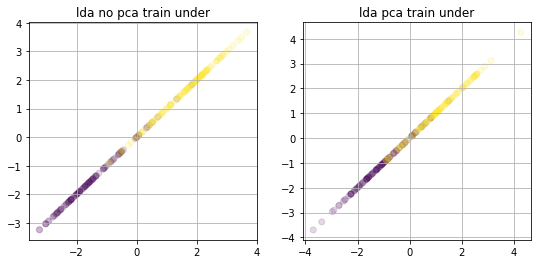

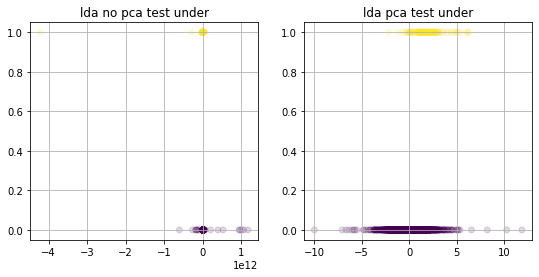

In [22]:
ldau=LDA()
lda_pcau=LDA()
ldau.fit(Xtrain_under,ytrain_under)
lda_pcau.fit(Xtrain_under_scaled_transf,ytrain_under)
scaler=StandardScaler()
scaler.fit(Xtest)
Xtest_scaled=scaler.transform(Xtest)

zldatru=ldau.transform(Xtrain_under)
zlda_pcatru=lda_pcau.transform(Xtrain_under_scaled_transf)
zldateu=ldau.transform(Xtest)
zlda_pcateu=lda_pcau.transform(pca_var1_under.transform(Xtest_scaled))

df_ldau = pd.DataFrame({'acc no pca under lda': [ldau.score(Xtrain_under, ytrain_under), ldau.score(Xtest, ytest)],
                       'acc pca under lda': [lda_pcau.score(Xtrain_under_scaled_transf, ytrain_under), 
                                             lda_pcau.score(pca_var1_under.transform(Xtest_scaled), ytest)]}, 
                      index=['train under', 'test'])
display(df_ldau)

fig1, axs1 = plt.subplots(1, 2, figsize=(9, 4))
axs1[0].scatter(zldatru.flatten(),zldatru.flatten(),c=ytrain_under,alpha=0.15)
axs1[1].scatter(zlda_pcatru.flatten(),zlda_pcatru.flatten(),c=ytrain_under,alpha=0.15)
axs1[0].set_title('lda no pca train under')
axs1[1].set_title('lda pca train under')
axs1[0].grid()
axs1[1].grid()
fig2, axs2 = plt.subplots(1, 2, figsize=(9, 4))
axs2[0].scatter(zldateu.flatten(),ytest,c=ytest,alpha=0.15)
axs2[1].scatter(zlda_pcateu.flatten(),ytest,c=ytest,alpha=0.15)
axs2[0].set_title('lda no pca test under')
axs2[1].set_title('lda pca test under')
axs2[0].grid()
axs2[1].grid()

In [23]:
y_predu = ldau.predict(Xtest)
y_pred_probau =ldau.predict_proba(Xtest)
y_pred_pcau = lda_pcau.predict(pca_var1_under.transform(Xtest_scaled))
y_pred_proba_pcau =lda_pcau.predict_proba(pca_var1_under.transform(Xtest_scaled))
y_pred_dfu = pd.DataFrame({'actual class test':ytest,
                          'pred class no pca': y_predu, 
                          'p(class 0) - % no pca': np.round(y_pred_probau[:, 0] * 100, decimals=2), 
                          'p(class 1) - % no pca': np.round(y_pred_probau[:, 1] * 100, decimals=2),
                          'pred class si pca': y_pred_pcau, 
                          'p(class 0) - % si pca': np.round(y_pred_proba_pcau[:, 0] * 100, decimals=2), 
                          'p(class 1) - % si pca': np.round(y_pred_proba_pcau[:, 1] * 100, decimals=2)})
infoldau=pd.DataFrame({'actual class':[list(y_pred_dfu["actual class test"]).count(0),list(y_pred_dfu["actual class test"]).count(1)],
                     'pred class lda no pca under':[list(y_pred_dfu["pred class no pca"]).count(0),list(y_pred_dfu["pred class no pca"]).count(1)],
                     'pred class lda pca under':[list(y_pred_dfu["pred class si pca"]).count(0),list(y_pred_dfu["pred class si pca"]).count(1)]})
display(infoldau)

,actual class,pred class lda no pca under,pred class lda pca under
0,3300,2671,1778
1,110,739,1632


In [24]:
acc_trainu = ldau.score(Xtrain_under, ytrain_under)
prec_trainu = precision_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')
rec_trainu = recall_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')
f1_trainu = f1_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')

acc_train_pcau = lda_pcau.score(pca_var1_under.transform(Xtrain_under_scaled), ytrain_under)
prec_train_pcau = precision_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')
rec_train_pcau = recall_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')
f1_train_pcau = f1_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')

acc_testu= ldau.score(Xtest, ytest)
prec_testu = precision_score(ytest,y_predu, average='weighted')
rec_testu = recall_score(ytest,y_predu, average='weighted')
f1_testu = f1_score(ytest,y_predu, average='weighted')

acc_test_pcau = lda_pcau.score(pca_var1_under.transform(Xtest_scaled), ytest)
prec_test_pcau = precision_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')
rec_test_pcau = recall_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')
f1_test_pcau = f1_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')

df_perfu = pd.DataFrame({'acc': [acc_trainu, acc_testu], 
                        'prec': [prec_trainu, prec_testu], 
                        'rec': [rec_trainu, rec_testu],
                        'f1': [f1_trainu, f1_testu]
                       },
                      index=['training lda no pca under', 'test lda no pca under'])
df_perfup = pd.DataFrame({'acc': [acc_train_pcau, acc_test_pcau], 
                        'prec': [prec_train_pcau, prec_test_pcau], 
                        'rec': [rec_train_pcau, rec_test_pcau],
                        'f1': [f1_train_pcau, f1_test_pcau]
                       },
                      index=['training lda pca under','test lda pca under'])

cmatu = confusion_matrix(ytest,y_predu)
df_cmatu = pd.DataFrame(cmatu, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])
cmatup = confusion_matrix(ytest,y_pred_pcau)
df_cmatup = pd.DataFrame(cmatup, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('Performance LDA senza PCA random undersampling')
print('')
display(df_perfu)
print('')
print('Confusion matrix LDA senza PCA random undersampling')
print('')
display(df_cmatu)
print('')
print('Performance LDA con PCA random undersampling')
print('')
display(df_perfup)
print('')
print('Confusion matrix LDA con PCA random undersampling')
print('')
display(df_cmatup)


Performance LDA senza PCA random undersampling



,acc,prec,rec,f1
training lda no pca under,0.918182,0.918320,0.918182,0.918175
test lda no pca under,0.797361,0.959959,0.797361,0.861752



Confusion matrix LDA senza PCA random undersampling



,no bancarotta,bancarotta
no bancarotta,2640,660
bancarotta,31,79



Performance LDA con PCA random undersampling



,acc,prec,rec,f1
training lda pca under,0.840909,0.840937,0.840909,0.840906
test lda pca under,0.549560,0.965968,0.549560,0.678833



Confusion matrix LDA con PCA random undersampling



,no bancarotta,bancarotta
no bancarotta,1771,1529
bancarotta,7,103


Analogamente al caso precedente i risultati non sono apprezzabili dal punto di vista grafico. Tuttavia nel grafico del training set la separazione tra le classi è molto più evidente rispetto al grafico del test set. Questo è dovuto ai dati riguardanti l'accuratezza, la precision, la recall e l'f1 score sono molto buoni nel training set mentre peggiorano per il test set. Ricalcolando il misclassification rate rispetto alla LDA random undersampling senza PCA e con PCA otteniamo rispettivamente 27% e 48%.    
In generale si può quindi concludere che la LDA con PCA e il random undersampling lavorano peggio rispetto alla LDA senza PCA e il random oversampling.

## Support Vector Machine (SVM) non lineari random oversampling

A differenza della PCA che mantiene la struttura metrico-statistica dei dati, nelle SVM si cerca l'iperpiano che massimizza la separazione tra punti. Questi ultimi quindi sono fissati, immobili, non vengono proiettati lungo particolari direzioni ma si cerca un separatore lineare che distacchi le classi nel miglior modo posibile. Sotto le ipotesi di lineare separabilità (ovvero esistono $w \in R^n$, $b \in R$ tali che $y_i(<w,x_i>+b)\geq0 \ \forall i=1,2...,m$, dove $\{(x_i,y_i)| x_i \in R^n, y_i \in R, i=1,2...,m\}$ è il data set di riferimento), l'obiettivo delle SVM è massimizzare il margine $margin=\{min \ d(\Pi_{w,b},x)|x \in dataset\}$. $\Pi_{w,b}$ rappresenta l'iperpiano separatore identificato dalla coppia (w,b). In generale possiamo distinguere due tipi di SVM lineari: le prime sono le SVM hard a cui corrisponde il problema di minimo:  
\begin{equation}
\begin{cases}
\min_{\boldsymbol{w}} \frac{1}{2}\boldsymbol{w}^\top\boldsymbol{w}\\
y_i (\boldsymbol{w}^\top\boldsymbol{x}_i + b) \geq 1 \,,\quad \forall \ i=1,\ldots ,T
\end{cases}
\end{equation}  
  
  
Il secondo tipo sono le soft SVM che vengono utilizzate quando i dati non sono perfettamente separabili. In questo caso vengono introdotte delle slack variable $\xi_i = \delta_i||w||$ e dei parametri di costo $C\in\mathbb{R}^+$ che permettono di poter violare il margine di una certa quantità $\delta_i$. Parametri di costo elevati implicano piccole violazioni mentre parametri di costo bassi permettono rilassamenti maggiori visto che il problema associato riguarda sempre la minimizzazione di un funzionale. Il problema di minimo viene quindi espresso nel seguente modo: 
  
\begin{equation}
\begin{cases}
\min_{\boldsymbol{w}} \frac{1}{2}\boldsymbol{w}^\top\boldsymbol{w} + C \sum_{i=1}^T \xi_i\\
y_i (\boldsymbol{w}^\top\boldsymbol{x}_i + b) \geq 1 - \xi_i \,,\quad & \forall \ i=1,\ldots ,T\\
\xi_i\geq 0\,,\quad & \forall \ i=1,\ldots ,T\\
\end{cases}\,,
\end{equation}
  
Nel caso di dati non linearmente separabili si utilizzano le SVM non lineari. I dati vengono proiettati in dimensione più alta grazie ad una mappa $\phi :\mathbb{R}^n\rightarrow \mathbb{R}^m\, \text{con }m>n\,$ così da poterli separare con una SVM lineare. Le criticità legate a questo tipo di SVM sono il costo computazionale e il problema della dimensionalità. Per definire il problema di minimo delle SVM non lineari partiamo dal problema duale associato ad una SVM lineare:  
  
\begin{equation}
\begin{cases}
\min_{\boldsymbol{\alpha}} \frac{1}{2}\boldsymbol{\alpha}^\top Q \boldsymbol{\alpha} - \sum_{i=1}^T \alpha_i\\
\sum_{i=1}^T \alpha_i y_i = 0\\
\alpha_i \geq 0\,,\quad \forall \ i=1,\ldots ,T
\end{cases}\,,
\end{equation}  
dove $\alpha\in\mathbb{R}^T$ e la matrice $Q\in\mathbb{R}^{T\times T}$ è tale che
$\begin{equation}
Q = \left(q_{i,j}\right)_{i,j=1,\ldots ,T} =  \left( y_iy_j x_i^\top x_j \right)_{i,j=1,\ldots ,T}\,.
\end{equation}$  
Apllicando la trasformazione $\phi$ ricaviamo il problema duale associato alla SVM non lineare:  
  
  
\begin{equation}
\begin{cases}
\min_{\boldsymbol{\alpha}} \frac{1}{2}\boldsymbol{\alpha}^\top Q' \boldsymbol{\alpha} - \sum_{i=1}^T \alpha_i\\
\sum_{i=1}^T \alpha_i y_i = 0\\
\alpha_i \geq 0\,,\quad \forall \ i=1,\ldots ,T
\end{cases}\,,
\end{equation}  
dove $\alpha\in\mathbb{R}^T$ e la matrice $Q'\in\mathbb{R}^{T\times T}$ è tale che
$\begin{equation}
Q' = \left(q_{i,j}\right)_{i,j=1,\ldots ,T} =  \left( y_iy_j\phi(x)_i^\top\phi(x)_j \right)_{i,j=1,\ldots ,T}\,.
\end{equation}$  
Le difficoltà di quest'ultimo problema di minimo stanno nel calcolo del prodotto scalare $\langle \phi_i , \phi\rangle = \phi(x)_i^\top\phi(x)$. Vengono definiti quindi i Kernel $k$ che sono funzioni $k:\mathcal{X}\times \mathcal{X}\rightarrow\mathbb{R}$ per cui esiste un'unica mappa $\phi:\mathcal{X}\rightarrow\mathcal{H}\subseteq\mathbb{R}^m\,,$ con $m>n$ ed $\mathcal{H}$ spazio di Hilbert, tale che $\langle\phi_i,\phi_j\rangle_{\mathcal{H}} = k(x_i,x_j)$. Il teorema di Moore assicura l'esistenza e l'unicità di questi Kernel. Nel seguito vengono elencati i principali Kernel utilizzzati nelle applicazioni:    
- Kernel Lineare: è il kernel corrispondente al caso in cui $\phi$ sia l'identità (cioè è il kernel delle SVM lineari).
$\begin{equation}
\langle \phi_i, \phi_j\rangle_{\mathcal{H}} = \langle x_i, x_j\rangle_{\mathcal{X}}\,,
\end{equation}$  
- Kernel Polinomiale: è un kernel caratterizzato da un'espressione di tipo polinomiale.
$\begin{equation}
\langle \phi_i, \phi_j\rangle_{\mathcal{H}} = \left(\gamma \, \langle x_i, x_j\rangle_{\mathcal{X}} + c_0 \right)^d\,;
\end{equation}$  
- Radial Basis Function (RBF) Kernel: è un kernel caratterizzato da un'espressione di tipo esponenziale.
$\begin{equation}
\langle \phi_i, \phi_j\rangle_{\mathcal{H}} = e^{-\gamma \, \langle x_i, x_j\rangle_{\mathcal{X}}^2}\,;
\end{equation}$  
- Kernel "Sigmoidale": è un kernel caratterizzato da un'espressione di tipo sigmoidale
$\begin{equation}
\langle \phi_i, \phi_j\rangle_{\mathcal{H}} = \mathrm{tanh}\left(\gamma \, \langle x_i, x_j\rangle_{\mathcal{X}} + c_0 \right)\,;
\end{equation}$

In [25]:
test_svm = 0.5
val_svm = 0.4
indices = np.arange(X.shape[0])
ind_train_svm, ind_test_svm = train_test_split(indices, test_size=test_svm, random_state=random_state, shuffle=True)
ind_train_svm, ind_val_svm = train_test_split(ind_train_svm, test_size=val_svm, random_state=random_state, shuffle=True)

Xtrain_svm=X.iloc[ind_train_svm,:]
ytrain_svm= y.iloc[ind_train_svm]
Xval_svm=X.iloc[ind_val_svm,:]
yval_svm= y.iloc[ind_val_svm]
Xtest_svm=X.iloc[ind_test_svm,:]
ytest_svm= y.iloc[ind_test_svm]

ros = RandomOverSampler(random_state=random_state)
Xtrain_over_svm, ytrain_over_svm = ros.fit_resample(Xtrain_svm, ytrain_svm)
Xval_over_svm, yval_over_svm = ros.fit_resample(Xval_svm, yval_svm)
cc = ClusterCentroids(random_state=random_state)
Xtrain_under_svm, ytrain_under_svm = cc.fit_resample(Xtrain_svm, ytrain_svm)
Xval_under_svm, yval_under_svm = cc.fit_resample(Xval_svm, yval_svm)

In [26]:
info_svm1=pd.DataFrame({'train svm':[list(ytrain_svm).count(0),list(ytrain_svm).count(1)],
                  'test svm':[list(ytest_svm).count(0),list(ytest_svm).count(1)]})
info_svm2=pd.DataFrame({'train over svm':[list(ytrain_over_svm).count(0),list(ytrain_over_svm).count(1)],
                  'train under svm':[list(ytrain_under_svm).count(0),list(ytrain_svm).count(1)],
                  'val over svm':[list(yval_over_svm).count(0),list(yval_over_svm).count(1)],
                  'val under svm':[list(yval_under_svm).count(0),list(yval_svm).count(1)],
                  'test svm':[list(ytest_svm).count(0),list(ytest_svm).count(1)]})
display(info_svm1)
display(info_svm2)

,train svm,test svm
0,1989,3294
1,56,116


,train over svm,train under svm,val over svm,val under svm,test svm
0,1989,56,1316,48,3294
1,1989,56,1316,48,116


Prima di applicare le SVM scegliamo di ridividere il data set secondo le seguenti proporzioni: training set 30%, validation set 20% e test set 50%. Le percentuali sono da intendere come frazione dell'intero data set. Nella ricerca a griglia degli iper-parametri ottimali per un generico problema risulta utile dividere il dataset non in due, ma in tre sottoinsiemi: training set, validation set e test set. Il validation set serve da pre-test set. Viene utilizzato ad esempio per la ricerca dei migliori iper-parametri, generalmente misurando le performance di modelli addestrati sul training set per avere una sottostima delle possibili performance finali sul test set. Normalmente il validation set è il sottoinsieme di dimensione più piccola, per questo motivo le performance sono una sottostima di quelle che si dovrebbero avere nel test set.  
Per cercare la miglior combinazione di iperparametri per un modello, si effettua una ricerca a griglia. Dato un intervallo discreto di valori $I_h$ per ogni iperparametro $p_h$, $h=1,\ldots , H$, si considera la griglia di punti generata dal prodotto cartesiano degli intervalli, cioè $G = I_1 \times \cdots \times I_H\,.$ Ogni punto di $G$ rappresenta una possibile combinazione degli iper-parametri del modello. In totale si considerano quindi i $K=|G|$ modelli caratterizzati dalle $K$ combinazioni di iper-parametri differenti e si cerca quello con le migliori performance sul validation set.

In [27]:
C_list = [i for i in range(1,6)]
kernel_list =['rbf','poly','sigmoid']
gamma_list = ['scale','auto']
hparameters = {'C': C_list, 'kernel': kernel_list}
svm = SVC(class_weight='balanced')
svm_gs = GridSearchCV(estimator=svm,
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train_svm], [ind_val_svm]))
svm_gs.fit(X, y)

GridSearchCV(cv=<zip object at 0x000001D86DA47900>,
             estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1, 2, 3, 4, 5],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             return_train_score=True, scoring='f1_weighted')

D'ora in avanti tutte le analisi verranno fatte sulla miglior SVM trovata dalla GridSearchCV.  

In [28]:
svm_gs.best_estimator_.fit(Xtrain_over_svm, ytrain_over_svm) 

y_pred_traino = svm_gs.best_estimator_.predict(Xtrain_over_svm)
y_true_traino = ytrain_over_svm
y_pred_testo = svm_gs.best_estimator_.predict(Xtest_svm)
y_true_testo = ytest_svm
y_pred_valo = svm_gs.best_estimator_.predict(Xval_over_svm)
y_true_valo = yval_over_svm

acc_traino = svm_gs.best_estimator_.score(Xtrain_over_svm, y_true_traino)
prec_traino = precision_score(y_true_traino,y_pred_traino, average='weighted')
rec_traino = recall_score(y_true_traino,y_pred_traino, average='weighted')
f1_traino = f1_score(y_true_traino,y_pred_traino, average='weighted')
acc_valo = svm_gs.best_estimator_.score(Xval_over_svm, y_true_valo)
prec_valo = precision_score(y_true_valo,y_pred_valo, average='weighted')
rec_valo = recall_score(y_true_valo,y_pred_valo, average='weighted')
f1_valo = f1_score(y_true_valo,y_pred_valo, average='weighted')
acc_testo = svm_gs.best_estimator_.score(Xtest_svm,y_true_testo)
prec_testo = precision_score(y_true_testo,y_pred_testo, average='weighted')
rec_testo = recall_score(y_true_testo,y_pred_testo, average='weighted')
f1_testo = f1_score(y_true_testo,y_pred_testo, average='weighted')

df_perf_svmo = pd.DataFrame({'acc': [acc_traino, acc_valo, acc_testo], 
                        'prec': [prec_traino, prec_valo, prec_testo], 
                        'rec': [rec_traino, rec_valo, rec_testo],
                        'f1': [f1_traino, f1_valo, f1_testo]
                       },
                      index=['train svm no pca over', 'val svm no pca over', 'test svm no pca over'])
cmat_svmo = confusion_matrix(y_true_testo,y_pred_testo)
df_cmat_svmo = pd.DataFrame(cmat_svmo, columns=['no bancarotta','bancarotta'], 
                            index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM senza PCA random oversampling')
print('')
display(df_perf_svmo)
print('')
print('Confusion matrix SVM senza PCA random oversampling')
print('')
display(df_cmat_svmo)


Performance SVM senza PCA random oversampling



,acc,prec,rec,f1
train svm no pca over,0.908245,0.910938,0.908245,0.908095
val svm no pca over,0.516717,0.530018,0.516717,0.456513
test svm no pca over,0.824340,0.942613,0.824340,0.875767



Confusion matrix SVM senza PCA random oversampling



,no bancarotta,bancarotta
no bancarotta,2771,523
bancarotta,76,40


In [29]:
scaler_svm_over=StandardScaler()
scaler_svm_over.fit(Xtrain_over_svm)
Xtrain_over_svm_scaled=scaler_svm_over.transform(Xtrain_over_svm)
scaler_svm_val=StandardScaler()
scaler_svm_val.fit(Xval_over_svm)
Xval_over_svm_scaled=scaler_svm_val.transform(Xval_over_svm)
scaler_svm_test=StandardScaler()
scaler_svm_test.fit(Xtest_svm)
Xtest_svm_scaled=scaler_svm_test.transform(Xtest_svm)

pca_svm_over=PCA(0.9)
pca_svm_over.fit(Xtrain_over_svm_scaled)
svm_gs.best_estimator_.fit(pca_svm_over.transform(Xtrain_over_svm_scaled), ytrain_over_svm) 

y_pred_trainop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xtrain_over_svm_scaled))
y_true_trainop = ytrain_over_svm
y_pred_testop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xtest_svm_scaled))
y_true_testop = ytest_svm
y_pred_valop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xval_over_svm_scaled))
y_true_valop = yval_over_svm

acc_trainop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xtrain_over_svm_scaled), y_true_trainop)
prec_trainop = precision_score(y_true_trainop,y_pred_trainop, average='weighted')
rec_trainop = recall_score(y_true_trainop,y_pred_trainop, average='weighted')
f1_trainop = f1_score(y_true_trainop,y_pred_trainop, average='weighted')
acc_valop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xval_over_svm_scaled), y_true_valop)
prec_valop = precision_score(y_true_valop,y_pred_valop, average='weighted')
rec_valop = recall_score(y_true_valop,y_pred_valop, average='weighted')
f1_valop = f1_score(y_true_valop,y_pred_valop, average='weighted')
acc_testop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xtest_svm_scaled),y_true_testop)
prec_testop = precision_score(y_true_testop,y_pred_testop, average='weighted')
rec_testop = recall_score(y_true_testop,y_pred_testop, average='weighted')
f1_testop = f1_score(y_true_testop,y_pred_testop, average='weighted')

df_perf_svmop = pd.DataFrame({'acc': [acc_trainop, acc_valop, acc_testop], 
                        'prec': [prec_trainop, prec_valop, prec_testop], 
                        'rec': [rec_trainop, rec_valop, rec_testop],
                        'f1': [f1_trainop, f1_valop, f1_testop]
                       },
                      index=['train svm over pca', 'val svm over pca', 'test svm over pca'])
cmat_svmop = confusion_matrix(y_true_testop,y_pred_testop)
df_cmat_svmop = pd.DataFrame(cmat_svmop, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM con PCA radom oversampling')
print('')
display(df_perf_svmop)
print('')
print('Confusion matrix SVM con PCA random oversampling')
print('')
display(df_cmat_svmop)


Performance SVM con PCA radom oversampling



,acc,prec,rec,f1
train svm over pca,0.976370,0.977436,0.976370,0.976357
val svm over pca,0.716185,0.769425,0.716185,0.701436
test svm over pca,0.754252,0.954507,0.754252,0.832376



Confusion matrix SVM con PCA random oversampling



,no bancarotta,bancarotta
no bancarotta,2494,800
bancarotta,38,78


I risultati ottenuti evidenziano che non esite una SVM (con o senza pca) nettamente migliore dell'altra. La scelta del modello migliore si baserà anche su quanta accuratezza si vuole avere nel predirre la classe bancarotta come tale. I misclassification rate dell'SVM random oversampling senza e con PCA sono rispettivamente 17% e 24%.

## SVM random undersampling

In [30]:
svm_gs.best_estimator_.fit(Xtrain_under_svm, ytrain_under_svm) 

y_pred_trainu = svm_gs.best_estimator_.predict(Xtrain_under_svm)
y_true_trainu = ytrain_under_svm
y_pred_testu = svm_gs.best_estimator_.predict(Xtest_svm)
y_true_testu = ytest_svm
y_pred_valu = svm_gs.best_estimator_.predict(Xval_under_svm)
y_true_valu = yval_under_svm

acc_trainu = svm_gs.best_estimator_.score(Xtrain_under_svm, y_true_trainu)
prec_trainu = precision_score(y_true_trainu,y_pred_trainu, average='weighted')
rec_trainu = recall_score(y_true_trainu,y_pred_trainu, average='weighted')
f1_trainu = f1_score(y_true_trainu,y_pred_trainu, average='weighted')
acc_valu = svm_gs.best_estimator_.score(Xval_under_svm, y_true_valu)
prec_valu = precision_score(y_true_valu,y_pred_valu, average='weighted')
rec_valu = recall_score(y_true_valu,y_pred_valu, average='weighted')
f1_valu = f1_score(y_true_valu,y_pred_valu, average='weighted')
acc_testu = svm_gs.best_estimator_.score(Xtest_svm,y_true_testu)
prec_testu = precision_score(y_true_testu,y_pred_testu, average='weighted')
rec_testu = recall_score(y_true_testu,y_pred_testu, average='weighted')
f1_testu = f1_score(y_true_testu,y_pred_testu, average='weighted')

df_perf_svmu = pd.DataFrame({'acc': [acc_trainu, acc_valu, acc_testu], 
                        'prec': [prec_trainu, prec_valu, prec_testu], 
                        'rec': [rec_trainu, rec_valu, rec_testu],
                        'f1': [f1_trainu, f1_valu, f1_testu]
                       },
                      index=['train svm no pca under', 'val svm no pca under', 'test svm no pca under'])
cmat_svmu = confusion_matrix(y_true_testu,y_pred_testu)
df_cmat_svmu = pd.DataFrame(cmat_svmu, columns=['no bancarotta','bancarotta'], 
                            index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM senza PCA random undersampling')
print('')
display(df_perf_svmu)
print('')
print('Confusion matrix SVM senza PCA random undersampling')
print('')
display(df_cmat_svmu)


Performance SVM senza PCA random undersampling



,acc,prec,rec,f1
train svm no pca under,0.785714,0.789032,0.785714,0.785098
val svm no pca under,0.562500,0.565336,0.562500,0.557701
test svm no pca under,0.537830,0.935150,0.537830,0.671671



Confusion matrix SVM senza PCA random undersampling



,no bancarotta,bancarotta
no bancarotta,1779,1515
bancarotta,61,55


In [31]:
scaler_svm_under=StandardScaler()
scaler_svm_under.fit(Xtrain_under_svm)
Xtrain_under_svm_scaled=scaler_svm_under.transform(Xtrain_under_svm)
scaler_svm_val_under=StandardScaler()
scaler_svm_val_under.fit(Xval_under_svm)
Xval_under_svm_scaled=scaler_svm_val.transform(Xval_under_svm)
scaler_svm_test_under=StandardScaler()

pca_svm_under=PCA(0.9)
pca_svm_under.fit(Xtrain_under_svm_scaled)
svm_gs.best_estimator_.fit(pca_svm_under.transform(Xtrain_under_svm_scaled), ytrain_under_svm) 

y_pred_trainup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xtrain_under_svm_scaled))
y_true_trainup = ytrain_under_svm
y_pred_testup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xtest_svm_scaled))
y_true_testup = ytest_svm
y_pred_valup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xval_under_svm_scaled))
y_true_valup = yval_under_svm

acc_trainup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xtrain_under_svm_scaled), y_true_trainup)
prec_trainup = precision_score(y_true_trainup,y_pred_trainup, average='weighted')
rec_trainup = recall_score(y_true_trainup,y_pred_trainup, average='weighted')
f1_trainup = f1_score(y_true_trainup,y_pred_trainup, average='weighted')
acc_valup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xval_under_svm_scaled), y_true_valup)
prec_valup = precision_score(y_true_valup,y_pred_valup, average='weighted')
rec_valup = recall_score(y_true_valup,y_pred_valup, average='weighted')
f1_valup = f1_score(y_true_valup,y_pred_valup, average='weighted')
acc_testup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xtest_svm_scaled),y_true_testup)
prec_testup = precision_score(y_true_testup,y_pred_testup, average='weighted')
rec_testup = recall_score(y_true_testup,y_pred_testup, average='weighted')
f1_testup = f1_score(y_true_testup,y_pred_testup, average='weighted')

df_perf_svmup = pd.DataFrame({'acc': [acc_trainup, acc_valup, acc_testup], 
                        'prec': [prec_trainup, prec_valup, prec_testup], 
                        'rec': [rec_trainup, rec_valup, rec_testup],
                        'f1': [f1_trainup, f1_valup, f1_testup]
                       },
                      index=['train svm under pca', 'val svm under pca', 'test svm under pca'])
cmat_svmup = confusion_matrix(y_true_testup,y_pred_testup)
df_cmat_svmup = pd.DataFrame(cmat_svmup, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM con PCA random undersampling')
print('')
display(df_perf_svmup)
print('')
print('Confusion matrix SVM con PCA random undersampling')
print('')
display(df_cmat_svmup)


Performance SVM con PCA random undersampling



,acc,prec,rec,f1
train svm under pca,0.991071,0.991228,0.991071,0.991071
val svm under pca,0.947917,0.952830,0.947917,0.947775
test svm under pca,0.416129,0.966348,0.416129,0.551466



Confusion matrix SVM con PCA random undersampling



,no bancarotta,bancarotta
no bancarotta,1305,1989
bancarotta,2,114


Le SVM nel caso del random undersampling non presentano ottimi risultati. Questo era intuibile da come sono stati bilanciati i dati inizialmente. Infatti, i dati di training nel caso del random undersampling sono molto piccoli (#{1}=56, #{0}=56) e questo non permette alle SVM di addestrarsi correttamente nel riconoscimento delle classi. Non a caso i misclassification rate delle SVM random undersampling con e senza PCA risultano essere rispettivamente 58% e 46%, ossia circa metà delle predizioni sono errate.

## Multi-Layer Perceptron (MLP) random oversampling

Gli MLP sono grafi multipartiti diretti. La loro struttura è composta da una serie di strati completamente connessi detti FC layers.  
Un FC layer è un'applicazione $\mathcal{L}:\mathbb{R}^n\rightarrow\mathbb{R}^m$ tale che
$\begin{equation}
\mathcal{L}(x) := \sigma\left(W x + b\right)\,,
\end{equation} \ $ dove: $\ W\in\mathbb{R}^{m\times n}$ è la matrice dei pesi, $\ b\in\mathbb{R}^m$ è il vettore dei bias e $\ \sigma:\mathbb{R}^m\rightarrow\mathbb{R}^m$ è una funzione vettoriale che applica elemento per elemento la funzione di attivazione $\sigma:\mathbb{R}\rightarrow\mathbb{R} \ $ ($\ \sigma$ non necessariamente lineare). Un generico MLP quindi può essere rappresentato dalla funzione $F:\mathbb{R}^n\rightarrow \mathbb{R}^m$ dove:  
  
  
\begin{equation}
F(x) : \mathbb{R}^n \xrightarrow[]{\mathcal{L}^{(1)}} \mathbb{R}^{n_1} \xrightarrow[]{\mathcal{L}^{(2)}} \cdots \xrightarrow[]{\mathcal{L}^{(H)}} \mathbb{R}^{n_H}\xrightarrow[]{\mathcal{L}^{(H+1)}}\mathbb{R}^m
\end{equation}  

$$\begin{equation}
F(x) = \sigma^{(H+1)}\left( W^{(H+1)}\sigma^{(H)}\left(\cdots \left( W^{(2)}\sigma^{(1)}\left(W^{(1)}x + b^{(1)}\right)+b^2\right) \cdots\right)  + b^{(H+1)}\right)\,,\quad \forall \ x\in\mathbb{R}^n\,.
\end{equation}$$  
$F(x)$ è una funzione parametrica con parametri $W^{(h)}$ e $b^{(h)}$. L'addestramento della MLP con una funzione parametrica $\hat{F}_w$ ha come fine quello di far apprendere $F$  e quindi risolvere il problema $\min_{w} \mathrm{Loss}(w)$.  
Esistono 3 approcci diversi a questo problema:  
- approccio niente stocasticità: $\begin{equation}\mathrm{Loss}_{\,\mathcal{T}}(w):=\sum_{i=1}^T |y_i - \hat{F}(x_i)| \ \,,
\end{equation}$ dove $y_i=F(x)$. Viene quindi fissata una loss e dei pesi all'MLP, successivamente finchè non si raggiunge un criterio di arresto i pesi vengono aggiornati con un generico metodo di discesa del gradiente.
- approccio stocasticità pura: $ \begin{equation}\mathrm{Loss}_{(x,y)}(w):= |y - \hat{F}(x)| \, \end{equation}$. In questo caso la loss è parametrica per ogni coppia di valori nel training set. Dopo aver assegnato i pesi iniziali finchè non si raggiunge un criterio di arresto si mescolano le coppie e si aggiornano i pesi per ogni coppia con un generico metodo di discesa del gradiente.
- metodo minibatch: $ \begin{equation} \mathrm{Loss}_{\,\mathcal{B}}(w):= \sum_{(x, y)\in\mathcal{B}}|y - \hat{F}(x)| \, \end{equation}$. Quest'ultimo è l'approccio più utilizzato perchè si definisce ancora una loss parametrica ma per un sottoinsieme $B$ estratto di punti e non per ogni coppia di punti del training set. Anche in questo caso dopo aver assegnato i pesi si fissa un numero $K\in\mathbb{N}$ di minibatch in cui dividere il training set e si procede analogamente agli altri metodi per ciascun minibatch.  

Un generico metodo di discesa del gradiente viene definito nel seguente modo:
$\begin{equation}
x_{k+1} = x_{k} - \alpha_{k}\nabla f(x_k)\,, \quad \forall \ k\geq 0\,,
\end{equation}$ dove $\alpha_k\in\mathbb{R}^+$ è un fattore di moltiplicazione del passo di discesa e $-\nabla f(x_k)$ è la direzione di più ripida discesa per $f$ nel punto $x_k$. Sotto opportune ipotesi per $f$ e nella scelta degli $\{\alpha_k\}_{k\in\mathbb{N}}$ si ha che il metodo del gradiente converge al punto di minimo assoluto di $f$.   
Nel caso dell'MLP vengono quindi definiti due parametri: l'epoca di addestramento e il learning rate $\alpha$. Il primo fa riferimento al numero di volte che vengono riaggiornati i pesi con un generico metodo di discesa del gradiente. $\alpha$ viene definito invece come il tasso di apprendimento, può variare da epoca a epoca e rappresenta il coefficiente per cui moltiplicare la direzione di massima discesa.   
Infine, i principali criteri di arresto per una rete neurale possono essere fissare un numero massimo $e_{\max}\in\mathbb{N}$ di epoche da eseguire oppure fissare una numero massimo $p\in\mathbb{N}$ di epoche di tolleranza rispetto al quale posso accettare che la loss sul validation set cresca invece di diminuire.

In [32]:
test_mlp = 0.5
val_mlp = 0.4

indices = np.arange(X.shape[0])
ind_trainval_mlp, ind_test_mlp = train_test_split(indices, test_size=test_mlp, random_state=random_state, shuffle=True)

Xtrainval_mlp=X.iloc[ind_trainval_mlp,:]
ytrainval_mlp=y.iloc[ind_trainval_mlp]
Xtest_mlp=X.iloc[ind_test_mlp,:]
ytest_mlp= y.iloc[ind_test_mlp]

ros = RandomOverSampler(random_state=random_state)
Xtrainval_over_mlp, ytrainval_over_mlp = ros.fit_resample(Xtrainval_mlp, ytrainval_mlp)
cc = ClusterCentroids(random_state=random_state)
Xtrainval_under_mlp, ytrainval_under_mlp = cc.fit_resample(Xtrainval_mlp, ytrainval_mlp)

info_mlp=pd.DataFrame({'trainval mlp':[list(ytrainval_mlp).count(0),list(ytrainval_mlp).count(1)],
                  'trainval over mlp':[list(ytrainval_over_mlp).count(0),list(ytrainval_over_mlp).count(1)],
                  'trainval under mlp':[list(ytrainval_under_mlp).count(0),list(ytrainval_under_mlp).count(1)],
                  'test mlp':[list(ytest_mlp).count(0),list(ytest_mlp).count(1)]})
display(info_mlp)

,trainval mlp,trainval over mlp,trainval under mlp,test mlp
0,3305,3305,104,3294
1,104,3305,104,116


Anche in questo caso vengono risuddivisi i diversi set di dati nello stesso modo, ossia training 30%, validation 20% e test 50%. Tuttavia, attraverso il nome trainval viene definito l'insieme dei dati che comprende sia il training che il validation set. Questa operazione è stata fatta dato che il validation set viene creato internamente dalla classe MLPClassifier. Successivamente, eseguiamo una ricerca a griglia dei migliori iperparametri riguardanti l'MLP. Le analisi che seguiranno verranno fatte sul miglior MLP trovato, analogamente a quanto fatto per le SVM.

In [33]:
hidden_layer_sizes = [64]
activation_list=['relu','logistic']
patience=75
max_epochs_list = [500,750,1000]
verbose = False
batch_sz = 4
hparameters = {'max_iter': max_epochs_list,
               'activation':activation_list}
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    verbose=verbose,n_iter_no_change=patience,
                    random_state=random_state, batch_size=batch_sz,
                    validation_fraction=val_mlp,solver='adam',
                    early_stopping=True)
mlp_gs = GridSearchCV(estimator=mlp,
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True)
mlp_gs.fit(X, y)

GridSearchCV(estimator=MLPClassifier(batch_size=4, early_stopping=True,
                                     hidden_layer_sizes=[64],
                                     n_iter_no_change=75, random_state=20210528,
                                     validation_fraction=0.4),
             param_grid={'activation': ['relu', 'logistic'],
                         'max_iter': [500, 750, 1000]},
             return_train_score=True, scoring='f1_weighted')

In [34]:
mlp_gs.best_estimator_.fit(Xtrainval_over_mlp,ytrainval_over_mlp)
y_pred_trainval_over_mlp = mlp_gs.best_estimator_.predict(Xtrainval_over_mlp)
y_pred_test_over_mlp = mlp_gs.best_estimator_.predict(Xtest_mlp)

acc_trainval_over_mlp = mlp_gs.best_estimator_.score(Xtrainval_over_mlp, ytrainval_over_mlp)
prec_trainval_over_mlp = precision_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted',zero_division=0)
rec_trainval_over_mlp = recall_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted')
f1_trainval_over_mlp = f1_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted')

acc_test_over_mlp = mlp_gs.best_estimator_.score(Xtest_mlp, ytest_mlp)
prec_test_over_mlp = precision_score(ytest_mlp, y_pred_test_over_mlp, average='weighted',zero_division=1)
rec_test_over_mlp = recall_score(ytest_mlp, y_pred_test_over_mlp, average='weighted')
f1_test_over_mlp = f1_score(ytest_mlp, y_pred_test_over_mlp, average='weighted')

df_perf_over_mlp = pd.DataFrame({'acc': [acc_trainval_over_mlp, acc_test_over_mlp], 
                        'prec': [prec_trainval_over_mlp, prec_test_over_mlp], 
                        'rec': [rec_trainval_over_mlp, rec_test_over_mlp],
                        'f1': [f1_trainval_over_mlp, f1_test_over_mlp]
                       },
                      index=['trainval mlp no pca over', 'test mlp no pca over'])

cmat_over_mlp = confusion_matrix(ytest_mlp, y_pred_test_over_mlp, labels=mlp_gs.best_estimator_.classes_)

df_cmat_over_mlp = pd.DataFrame(cmat_over_mlp, columns=['no bancarotta','bancarotta'],
                                index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP senza PCA random oversampling')
print('')
display(df_perf_over_mlp)
print('')
print('Confusion matrix MLP senza PCA random oversampling')
print('')
display(df_cmat_over_mlp)


Performance MLP senza PCA random oversampling



,acc,prec,rec,f1
trainval mlp no pca over,0.893797,0.894103,0.893797,0.893777
test mlp no pca over,0.840762,0.937422,0.840762,0.884538



Confusion matrix MLP senza PCA random oversampling



,no bancarotta,bancarotta
no bancarotta,2843,451
bancarotta,92,24


In [35]:
scaler_mlp_over=StandardScaler()
scaler_mlp_over.fit(Xtrainval_over_mlp)
Xtrainval_over_mlp_scaled=scaler_mlp_over.transform(Xtrainval_over_mlp)
scaler_mlp_test=StandardScaler()
scaler_mlp_test.fit(Xtest_mlp)
Xtest_mlp_scaled=scaler_mlp_test.transform(Xtest_mlp)

pca_mlp_over=PCA(0.9)
pca_mlp_over.fit(Xtrainval_over_mlp_scaled)
Xtrainval_over_mlp_scaled_transf=pca_mlp_over.transform(Xtrainval_over_mlp_scaled)
Xtest_mlp_scaled_transf=pca_mlp_over.transform(Xtest_mlp_scaled)
mlp_gs.best_estimator_.fit(Xtrainval_over_mlp_scaled_transf, ytrainval_over_mlp) 

y_pred_trainvalop = mlp_gs.best_estimator_.predict(Xtrainval_over_mlp_scaled_transf)
y_true_trainvalop = ytrainval_over_mlp
y_pred_testop = mlp_gs.best_estimator_.predict(Xtest_mlp_scaled_transf)
y_true_testop = ytest_mlp

acc_trainvalop = mlp_gs.best_estimator_.score(Xtrainval_over_mlp_scaled_transf, y_true_trainvalop)
prec_trainvalop = precision_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
rec_trainvalop = recall_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
f1_trainvalop = f1_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
acc_testop = mlp_gs.best_estimator_.score(Xtest_mlp_scaled_transf,y_true_testop)
prec_testop = precision_score(y_true_testop,y_pred_testop, average='weighted')
rec_testop = recall_score(y_true_testop,y_pred_testop, average='weighted')
f1_testop = f1_score(y_true_testop,y_pred_testop, average='weighted')

df_perf_mlpop = pd.DataFrame({'acc': [acc_trainvalop, acc_testop], 
                        'prec': [prec_trainvalop, prec_testop], 
                        'rec': [rec_trainvalop, rec_testop],
                        'f1': [f1_trainvalop, f1_testop]
                       },
                      index=['train mlp over pca', 'test mlp over pca'])
cmat_mlpop = confusion_matrix(y_true_testop,y_pred_testop)
df_cmat_mlpop = pd.DataFrame(cmat_mlpop, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP con PCA random oversampling')
print('')
display(df_perf_mlpop)
print('')
print('Confusion matrix MLP con PCA random oversampling')
print('')
display(df_cmat_mlpop)


Performance MLP con PCA random oversampling



,acc,prec,rec,f1
train mlp over pca,0.995159,0.995205,0.995159,0.995159
test mlp over pca,0.842815,0.958386,0.842815,0.889255



Confusion matrix MLP con PCA random oversampling



,no bancarotta,bancarotta
no bancarotta,2794,500
bancarotta,36,80


Anche in questo caso valgono osservazioni simili a quelle già fatte nel caso della SVM random oversampling con o senza PCA per quanto riguarda la scelta del metodo migliore. Tuttavia gli score con PCA risultano leggermente migliori rispetto a quelli senza PCA in questo caso, al contrario di quanto accadeva nelle SVM. Infine, i misclassification rate per l'MLP random oversampling senza e con PCA risultano essere entrambi circa del 16%.

## MLP random undersampling

In [36]:
mlp_gs.best_estimator_.fit(Xtrainval_under_mlp,ytrainval_under_mlp)
y_pred_trainval_under_mlp = mlp_gs.best_estimator_.predict(Xtrainval_under_mlp)
y_pred_test_under_mlp = mlp_gs.best_estimator_.predict(Xtest_mlp)

acc_trainval_under_mlp = mlp_gs.best_estimator_.score(Xtrainval_under_mlp, ytrainval_under_mlp)
prec_trainval_under_mlp = precision_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted',zero_division=0)
rec_trainval_under_mlp = recall_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted')
f1_trainval_under_mlp = f1_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted')

acc_test_under_mlp = mlp_gs.best_estimator_.score(Xtest_mlp, ytest_mlp)
prec_test_under_mlp = precision_score(ytest_mlp, y_pred_test_under_mlp, average='weighted',zero_division=1)
rec_test_under_mlp = recall_score(ytest_mlp, y_pred_test_under_mlp, average='weighted')
f1_test_under_mlp = f1_score(ytest_mlp, y_pred_test_under_mlp, average='weighted')

df_perf_under_mlp = pd.DataFrame({'acc': [acc_trainval_under_mlp, acc_test_under_mlp], 
                        'prec': [prec_trainval_under_mlp, prec_test_under_mlp], 
                        'rec': [rec_trainval_under_mlp, rec_test_under_mlp],
                        'f1': [f1_trainval_under_mlp, f1_test_under_mlp]
                       },
                      index=['trainval mlp no pca under', 'test mlp no pca under'])

cmat_under_mlp = confusion_matrix(ytest_mlp, y_pred_test_under_mlp, labels=mlp_gs.best_estimator_.classes_)

df_cmat_under_mlp = pd.DataFrame(cmat_under_mlp, columns=['no bancarotta','bancarotta'], 
                                 index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP senza PCA random undersampling')
print('')
display(df_perf_under_mlp)
print('')
print('Confusion matrix MLP senza PCA random undersampling')
print('')
display(df_cmat_under_mlp)


Performance MLP senza PCA random undersampling



,acc,prec,rec,f1
trainval mlp no pca under,0.807692,0.811844,0.807692,0.807050
test mlp no pca under,0.508504,0.938102,0.508504,0.645632



Confusion matrix MLP senza PCA random undersampling



,no bancarotta,bancarotta
no bancarotta,1670,1624
bancarotta,52,64


In [37]:
scaler_mlp_under=StandardScaler()
scaler_mlp_under.fit(Xtrainval_under_mlp)
Xtrainval_under_mlp_scaled=scaler_mlp_under.transform(Xtrainval_under_mlp)
scaler_mlp_test=StandardScaler()
scaler_mlp_test.fit(Xtest_mlp)
Xtest_mlp_scaled=scaler_mlp_test.transform(Xtest_mlp)

pca_mlp_under=PCA(0.9)
pca_mlp_under.fit(Xtrainval_under_mlp_scaled)
mlp_gs.best_estimator_.fit(pca_mlp_under.transform(Xtrainval_under_mlp_scaled), ytrainval_under_mlp)

y_pred_trainvalup = mlp_gs.best_estimator_.predict(pca_mlp_under.transform(Xtrainval_under_mlp_scaled))
y_true_trainvalup = ytrainval_under_mlp
y_pred_testup = mlp_gs.best_estimator_.predict(pca_mlp_under.transform(Xtest_mlp_scaled))
y_true_testup = ytest_mlp

acc_trainvalup = mlp_gs.best_estimator_.score(pca_mlp_under.transform(Xtrainval_under_mlp_scaled), y_true_trainvalup)
prec_trainvalup = precision_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
rec_trainvalup = recall_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
f1_trainvalup = f1_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
acc_testup = mlp_gs.best_estimator_.score(pca_mlp_under.transform(Xtest_mlp_scaled),y_true_testup)
prec_testup = precision_score(y_true_testup,y_pred_testup, average='weighted')
rec_testup = recall_score(y_true_testup,y_pred_testup, average='weighted')
f1_testup = f1_score(y_true_testup,y_pred_testup, average='weighted')

df_perf_mlpup = pd.DataFrame({'acc': [acc_trainvalup, acc_testup], 
                        'prec': [prec_trainvalup, prec_testup], 
                        'rec': [rec_trainvalup, rec_testup],
                        'f1': [f1_trainvalup, f1_testup]
                       },
                      index=['train mlp under pca', 'test mlp under pca'])
cmat_mlpup = confusion_matrix(y_true_testup,y_pred_testup)
df_cmat_mlpup = pd.DataFrame(cmat_mlpup, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP con PCA random undersampling')
print('')
display(df_perf_mlpup)
print('')
print('Confusion matrix MLP con PCA random undersampling')
print('')
display(df_cmat_mlpup)


Performance MLP con PCA random undersampling



,acc,prec,rec,f1
train mlp under pca,0.985577,0.985622,0.985577,0.985577
test mlp under pca,0.432551,0.967182,0.432551,0.568055



Confusion matrix MLP con PCA random undersampling



,no bancarotta,bancarotta
no bancarotta,1360,1934
bancarotta,1,115


Sebbene il numero dei dati di training più validation nel caso dell' MLP random undersampling sia il doppio di quelli del training dell'SVM random undersampling le conclusioni sono sempre le stesse visto che si parla in entrambi i casi di numeri piccoli (SVM random undersampling: #{1}=56, #{0}=56. MLP random undersampling: #{1}=104, #{0}=104). Infine, i misclassification rate dell'MLP random oversampling senza e con PCA risultano essere rispettivamente 49% e 57%.

## Confronto dei metodi utilizzati random oversapling & random undersampling

In generale si può osservare che i modelli più corretti hanno ottimi score grazie al maggior numero di predizioni corrette dei casi di non bancarotta rispetto a quelli di bancarotta. Questo è dovuto all'iniziale squilibrio delle classi presenti nel dataset.

In [38]:
print('')
print('LDA OVER')
display(df_perfo)
display(df_cmato)
display(df_perfop)
display(df_cmatop)
print('')
print('Misclassification rate LDA random oversampling senza PCA=13%')
print('Misclassification rate LDA random oversampling con PCA=45%')
print('')
print('')
print('LDA UNDER')
display(df_perfu)
display(df_cmatu)
display(df_perfup)
display(df_cmatup)
print('')
print('Misclassification rate LDA random undersampling senza PCA=27%')
print('Misclassification rate LDA random undersampling con PCA=48%')
print('')
print('')
print('SVM OVER')
display(df_perf_svmo)
display(df_cmat_svmo)
display(df_perf_svmop)
display(df_cmat_svmop)
print('')
print('Misclassification rate SVM random oversampling senza PCA=17%')
print('Misclassification rate SVM random oversampling con PCA=24%')
print('')
print('')
print('SVM UNDER')
display(df_perf_svmu)
display(df_cmat_svmu)
display(df_perf_svmup)
display(df_cmat_svmup)
print('')
print('Misclassification rate SVM random undersampling senza PCA=46%')
print('Misclassification rate SVM random undersampling con PCA=58%')
print('')
print('')
print('MLP OVER')
display(df_perf_over_mlp)
display(df_cmat_over_mlp)
display(df_perf_mlpop)
display(df_cmat_mlpop)
print('')
print('Misclassification rate MLP random oversampling senza PCA=16% (nel dettaglio 15.9%)')
print('Misclassification rate MLP random oversampling con PCA=16% (nel dettaglio 15.7%)')
print('')
print('')
print('MLP UNDER')
display(df_perf_under_mlp)
display(df_cmat_under_mlp)
display(df_perf_mlpup)
display(df_cmat_mlpup)
print('Misclassification rate MLP random undersampling senza PCA=49%')
print('Misclassification rate MLP random undersampling con PCA=57%')


LDA OVER


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


,acc,prec,rec,f1
train lda pca over,0.873143,0.873733,0.873143,0.873093
test lda pca over,0.548387,0.967635,0.548387,0.677580


,no bancarotta,bancarotta
no bancarotta,1764,1536
bancarotta,4,106



Misclassification rate LDA random oversampling senza PCA=13%
Misclassification rate LDA random oversampling con PCA=45%


LDA UNDER


,acc,prec,rec,f1
training lda no pca under,0.918182,0.918320,0.918182,0.918175
test lda no pca under,0.797361,0.959959,0.797361,0.861752


,no bancarotta,bancarotta
no bancarotta,2640,660
bancarotta,31,79


,acc,prec,rec,f1
training lda pca under,0.840909,0.840937,0.840909,0.840906
test lda pca under,0.549560,0.965968,0.549560,0.678833


,no bancarotta,bancarotta
no bancarotta,1771,1529
bancarotta,7,103



Misclassification rate LDA random undersampling senza PCA=27%
Misclassification rate LDA random undersampling con PCA=48%


SVM OVER


,acc,prec,rec,f1
train svm no pca over,0.908245,0.910938,0.908245,0.908095
val svm no pca over,0.516717,0.530018,0.516717,0.456513
test svm no pca over,0.824340,0.942613,0.824340,0.875767


,no bancarotta,bancarotta
no bancarotta,2771,523
bancarotta,76,40


,acc,prec,rec,f1
train svm over pca,0.976370,0.977436,0.976370,0.976357
val svm over pca,0.716185,0.769425,0.716185,0.701436
test svm over pca,0.754252,0.954507,0.754252,0.832376


,no bancarotta,bancarotta
no bancarotta,2494,800
bancarotta,38,78



Misclassification rate SVM random oversampling senza PCA=17%
Misclassification rate SVM random oversampling con PCA=24%


SVM UNDER


,acc,prec,rec,f1
train svm no pca under,0.785714,0.789032,0.785714,0.785098
val svm no pca under,0.562500,0.565336,0.562500,0.557701
test svm no pca under,0.537830,0.935150,0.537830,0.671671


,no bancarotta,bancarotta
no bancarotta,1779,1515
bancarotta,61,55


,acc,prec,rec,f1
train svm under pca,0.991071,0.991228,0.991071,0.991071
val svm under pca,0.947917,0.952830,0.947917,0.947775
test svm under pca,0.416129,0.966348,0.416129,0.551466


,no bancarotta,bancarotta
no bancarotta,1305,1989
bancarotta,2,114



Misclassification rate SVM random undersampling senza PCA=46%
Misclassification rate SVM random undersampling con PCA=58%


MLP OVER


,acc,prec,rec,f1
trainval mlp no pca over,0.893797,0.894103,0.893797,0.893777
test mlp no pca over,0.840762,0.937422,0.840762,0.884538


,no bancarotta,bancarotta
no bancarotta,2843,451
bancarotta,92,24


,acc,prec,rec,f1
train mlp over pca,0.995159,0.995205,0.995159,0.995159
test mlp over pca,0.842815,0.958386,0.842815,0.889255


,no bancarotta,bancarotta
no bancarotta,2794,500
bancarotta,36,80



Misclassification rate MLP random oversampling senza PCA=16% (nel dettaglio 15.9%)
Misclassification rate MLP random oversampling con PCA=16% (nel dettaglio 15.7%)


MLP UNDER


,acc,prec,rec,f1
trainval mlp no pca under,0.807692,0.811844,0.807692,0.807050
test mlp no pca under,0.508504,0.938102,0.508504,0.645632


,no bancarotta,bancarotta
no bancarotta,1670,1624
bancarotta,52,64


,acc,prec,rec,f1
train mlp under pca,0.985577,0.985622,0.985577,0.985577
test mlp under pca,0.432551,0.967182,0.432551,0.568055


,no bancarotta,bancarotta
no bancarotta,1360,1934
bancarotta,1,115


Misclassification rate MLP random undersampling senza PCA=49%
Misclassification rate MLP random undersampling con PCA=57%


Confrontando le diverse tabelle emerge che la LDA random oversampling senza PCA sia il metodo migliore in termini predittivi. Oltre a questo metodo anche l'MLP random oversampling con e senza pca, l'SVM random oversampling con e senza PCA e la LDA random undersampling senza PCA funzionano molto bene. In generale quindi il random oversampling funziona meglio dell'under-sampling mentre la PCA non sempre è superflua. Come già detto, il motivo principale dello scarso funzionamento del random undrsampling potrebbe esser dovuto all'eccessivo sbilanciamento delle classi che a diminuire in maniera eccessiva il numero di "1", ossia i casi di bancarotta, rendendo più difficile la predizione.

## Analisi delle features fondamentali

Nel seguito della trattazione viene effettuata una analisi delle categorie di Financial ratios fondamentali. L'obiettivo è testare il miglior metodo trovato fino a questo punto (LDA random oversampling senza PCA) applicandolo al data set senza una categoria in particolare. Facendo così si potrà osservare quali categorie sono più critiche e quindi utili nella predizione della bancarotta.

## Data set senza solvency

In [39]:
Xtrains=Xtrain_over.copy()
ytrains=ytrain_over.copy()
Xtrains=Xtrains.drop([Xtrains.columns[94],Xtrains.columns[84],Xtrains.columns[83]],axis=1)
Xtrains=Xtrains.drop([Xtrains.columns[i] for i in range(53,67)],axis=1) 
Xtrains=Xtrains.drop([Xtrains.columns[i] for i in range(39,43)],axis=1) 
Xtrains=Xtrains.drop([Xtrains.columns[i] for i in range(31,37)],axis=1) 
Xtrains=Xtrains.drop([Xtrains.columns[13]],axis=1)

Xtests=Xtest.copy()
ytests=ytest.copy()
Xtests=Xtests.drop([Xtests.columns[94],Xtests.columns[84],Xtests.columns[83]],axis=1)
Xtests=Xtests.drop([Xtests.columns[i] for i in range(53,67)],axis=1) 
Xtests=Xtests.drop([Xtests.columns[i] for i in range(39,43)],axis=1) 
Xtests=Xtests.drop([Xtests.columns[i] for i in range(31,37)],axis=1) 
Xtests=Xtests.drop([Xtests.columns[13]],axis=1)

#display(Xtrain_over.shape)
#display(Xtrains.shape)
#display(Xtest.shape)
#display(Xtests.shape)

In [40]:
ldas=LDA()
ldas.fit(Xtrains,ytrains)
y_preds= ldas.predict(Xtests)

acc_trains = ldas.score(Xtrains, ytrains)
prec_trains = precision_score(ytrains,ldas.predict(Xtrains), average='weighted')
rec_trains = recall_score(ytrains,ldas.predict(Xtrains), average='weighted')
f1_trains = f1_score(ytrains,ldas.predict(Xtrains), average='weighted')

acc_tests = ldas.score(Xtests, ytests)
prec_tests = precision_score(ytests,y_preds, average='weighted')
rec_tests = recall_score(ytests,y_preds, average='weighted')
f1_tests = f1_score(ytests,y_preds, average='weighted')

df_perfs = pd.DataFrame({'acc': [acc_trains, acc_tests], 
                        'prec': [prec_trains, prec_tests], 
                        'rec': [rec_trains, rec_tests],
                        'f1': [f1_trains, f1_tests]
                       },
                      index=['train lda no pca no solvency over', 'test lda no pca no solvency over'])

cmats = confusion_matrix(ytests,y_preds)
df_cmats = pd.DataFrame(cmats, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])


print('')
print('LDA random oversampling no solvency')
display(df_perfs)
display(df_cmats)
print('')
print('LDA random oversampling all')
display(df_perfo)
display(df_cmato)


LDA random oversampling no solvency


,acc,prec,rec,f1
train lda no pca no solvency over,0.891028,0.891455,0.891028,0.890998
test lda no pca no solvency over,0.867155,0.965847,0.867155,0.905958


,no bancarotta,bancarotta
no bancarotta,2869,431
bancarotta,22,88



LDA random oversampling all


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


Gli score restano circa invariati.

## Data set senza profitability

In [41]:
Xtrainp=Xtrain_over.copy()
ytrainp=ytrain_over.copy()
Xtrainp=Xtrainp.drop([Xtrainp.columns[93],Xtrainp.columns[89],Xtrainp.columns[88],Xtrainp.columns[85]],axis=1)
Xtrainp=Xtrainp.drop([Xtrainp.columns[69],Xtrainp.columns[68],Xtrainp.columns[67]],axis=1) 
Xtrainp=Xtrainp.drop([Xtrainp.columns[22],Xtrainp.columns[18]],axis=1) 
Xtrainp=Xtrainp.drop([Xtrainp.columns[i] for i in range(0,10)],axis=1) 

Xtestp=Xtest.copy()
ytestp=ytest.copy()
Xtestp=Xtestp.drop([Xtestp.columns[93],Xtestp.columns[89],Xtestp.columns[88],Xtestp.columns[85]],axis=1)
Xtestp=Xtestp.drop([Xtestp.columns[69],Xtestp.columns[68],Xtestp.columns[67]],axis=1) 
Xtestp=Xtestp.drop([Xtestp.columns[22],Xtestp.columns[18]],axis=1) 
Xtestp=Xtestp.drop([Xtestp.columns[i] for i in range(0,10)],axis=1)

#display(Xtrain_over.shape)
#display(Xtrainp.shape)
#display(Xtest.shape)
#display(Xtestp.shape)

In [42]:
ldap=LDA()
ldap.fit(Xtrainp,ytrainp)
y_predp= ldap.predict(Xtestp)

acc_trainp = ldap.score(Xtrainp, ytrainp)
prec_trainp = precision_score(ytrainp,ldap.predict(Xtrainp), average='weighted')
rec_trainp = recall_score(ytrainp,ldap.predict(Xtrainp), average='weighted')
f1_trainp = f1_score(ytrainp,ldap.predict(Xtrainp), average='weighted')

acc_testp = ldap.score(Xtestp, ytestp)
prec_testp = precision_score(ytestp,y_predp, average='weighted')
rec_testp = recall_score(ytestp,y_predp, average='weighted')
f1_testp = f1_score(ytestp,y_predp, average='weighted')

df_perfp = pd.DataFrame({'acc': [acc_trainp, acc_testp], 
                        'prec': [prec_trainp, prec_testp], 
                        'rec': [rec_trainp, rec_testp],
                        'f1': [f1_trainp, f1_testp]
                       },
                      index=['train lda no pca no profitability over', 'test lda no pca no profitability over'])

cmatp = confusion_matrix(ytestp,y_predp)
df_cmatp = pd.DataFrame(cmatp, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('LDA random oversampling no profitability')
display(df_perfp)
display(df_cmatp)
print('')
print('LDA random oversampling all')
display(df_perfo)
display(df_cmato)


LDA random oversampling no profitability


,acc,prec,rec,f1
train lda no pca no profitability over,0.886329,0.886841,0.886329,0.886292
test lda no pca no profitability over,0.855425,0.961996,0.855425,0.898233


,no bancarotta,bancarotta
no bancarotta,2838,462
bancarotta,31,79



LDA random oversampling all


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


Gli score peggiorano anche se di poco.

## Data set senza turnover ratios

In [43]:
Xtraint=Xtrain_over.copy()
ytraint=ytrain_over.copy()
Xtraint=Xtraint.drop([Xtraint.columns[87]],axis=1)
Xtraint=Xtraint.drop([Xtraint.columns[i] for i in range(70,75)],axis=1) 
Xtraint=Xtraint.drop([Xtraint.columns[i] for i in range(43,50)],axis=1) 

Xtestt=Xtest.copy()
ytestt=ytest.copy()
Xtestt=Xtestt.drop([Xtestt.columns[87]],axis=1)
Xtestt=Xtestt.drop([Xtestt.columns[i] for i in range(70,75)],axis=1) 
Xtestt=Xtestt.drop([Xtestt.columns[i] for i in range(43,50)],axis=1) 

#display(Xtrain_over.shape)
#display(Xtraint.shape)
#display(Xtest.shape)
#display(Xtestt.shape)

In [44]:
ldat=LDA()
ldat.fit(Xtraint,ytraint)
y_predt= ldat.predict(Xtestt)

acc_traint = ldat.score(Xtraint, ytraint)
prec_traint = precision_score(ytraint,ldat.predict(Xtraint), average='weighted')
rec_traint = recall_score(ytraint,ldat.predict(Xtraint), average='weighted')
f1_traint = f1_score(ytraint,ldat.predict(Xtraint), average='weighted')

acc_testt = ldat.score(Xtestt, ytestt)
prec_testt = precision_score(ytestt,y_predt, average='weighted')
rec_testt = recall_score(ytestt,y_predt, average='weighted')
f1_testt = f1_score(ytestt,y_predt, average='weighted')

df_perft = pd.DataFrame({'acc': [acc_traint, acc_testt], 
                        'prec': [prec_traint, prec_testt], 
                        'rec': [rec_traint, rec_testt],
                        'f1': [f1_traint, f1_testt]
                       },
                      index=['train lda no pca no turnover ratios over', 'test lda no pca no turnover ratios over'])

cmatt = confusion_matrix(ytestt,y_predt)
df_cmatt = pd.DataFrame(cmatt, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('LDA random oversampling no turnover ratios')
display(df_perft)
display(df_cmatt)
print('')
print('LDA random oversampling all')
display(df_perfo)
display(df_cmato)


LDA random oversampling no turnover ratios


,acc,prec,rec,f1
train lda no pca no turnover ratios over,0.876629,0.877179,0.876629,0.876584
test lda no pca no turnover ratios over,0.859531,0.964402,0.859531,0.901074


,no bancarotta,bancarotta
no bancarotta,2846,454
bancarotta,25,85



LDA random oversampling all


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


Gli score restano circa invariati.

## Data set senza capital structure ratios

In [45]:
Xtrainsr=Xtrain_over.copy()
ytrainsr=ytrain_over.copy()
Xtrainsr=Xtrainsr.drop([Xtrainsr.columns[i] for i in range(90,93)],axis=1) 
Xtrainsr=Xtrainsr.drop([Xtrainsr.columns[i] for i in range(75,79)],axis=1) 
Xtrainsr=Xtrainsr.drop([Xtrainsr.columns[38],Xtrainsr.columns[37]],axis=1)
Xtestsr=Xtest.copy()
ytestsr=ytest.copy()
Xtestsr=Xtestsr.drop([Xtestsr.columns[i] for i in range(90,93)],axis=1) 
Xtestsr=Xtestsr.drop([Xtestsr.columns[i] for i in range(75,79)],axis=1) 
Xtestsr=Xtestsr.drop([Xtestsr.columns[38],Xtrainsr.columns[37]],axis=1)
#display(Xtrain_over.shape)
#display(Xtrainsr.shape)
#display(Xtest.shape)
#display(Xtestsr.shape)

In [46]:
ldasr=LDA()
ldasr.fit(Xtrainsr,ytrainsr)
y_predsr= ldasr.predict(Xtestsr)

acc_trainsr = ldasr.score(Xtrainsr, ytrainsr)
prec_trainsr = precision_score(ytrainsr,ldasr.predict(Xtrainsr), average='weighted')
rec_trainsr = recall_score(ytrainsr,ldasr.predict(Xtrainsr), average='weighted')
f1_trainsr = f1_score(ytrainsr,ldasr.predict(Xtrainsr), average='weighted')

acc_testsr = ldasr.score(Xtestsr, ytestsr)
prec_testsr = precision_score(ytestsr,y_predsr, average='weighted')
rec_testsr = recall_score(ytestsr,y_predsr, average='weighted')
f1_testsr = f1_score(ytestsr,y_predsr, average='weighted')

df_perfsr = pd.DataFrame({'acc': [acc_trainsr, acc_testsr], 
                        'prec': [prec_trainsr, prec_testsr], 
                        'rec': [rec_trainsr, rec_testsr],
                        'f1': [f1_trainsr, f1_testsr]
                       },
                      index=['train lda no pca no cap struct ratios over', 'test lda no pca no cap struct ratio over'])

cmatsr = confusion_matrix(ytestsr,y_predsr)
df_cmatsr = pd.DataFrame(cmatsr, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('LDA random oversampling no capital structure ratios')
display(df_perfsr)
display(df_cmatsr)
print('')
print('LDA random oversampling all')
display(df_perfo)
display(df_cmato)


LDA random oversampling no capital structure ratios


,acc,prec,rec,f1
train lda no pca no cap struct ratios over,0.896332,0.897027,0.896332,0.896287
test lda no pca no cap struct ratio over,0.031672,0.323585,0.031672,0.003117


,no bancarotta,bancarotta
no bancarotta,2,3298
bancarotta,4,106



LDA random oversampling all


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


Gli score peggiorano nettamente.

## Data set senza cash flow ratios

In [47]:
Xtraincf=Xtrain_over.copy()
ytraincf=ytrain_over.copy()
Xtraincf=Xtraincf.drop([Xtraincf.columns[i] for i in range(79,83)],axis=1) 
Xtraincf=Xtraincf.drop([Xtraincf.columns[12]],axis=1)
Xtestcf=Xtest.copy()
ytestcf=ytest.copy()
Xtestcf=Xtestcf.drop([Xtestcf.columns[i] for i in range(79,83)],axis=1) 
Xtestcf=Xtestcf.drop([Xtestcf.columns[12]],axis=1)
#display(Xtrain_over.shape)
#display(Xtraincf.shape)
#display(Xtest.shape)
#display(Xtestcf.shape)

In [48]:
ldacf=LDA()
ldacf.fit(Xtraincf,ytraincf)
y_predcf= ldacf.predict(Xtestcf)

acc_traincf = ldacf.score(Xtraincf, ytraincf)
prec_traincf = precision_score(ytraincf,ldacf.predict(Xtraincf), average='weighted')
rec_traincf = recall_score(ytraincf,ldacf.predict(Xtraincf), average='weighted')
f1_traincf = f1_score(ytraincf,ldacf.predict(Xtraincf), average='weighted')

acc_testcf = ldacf.score(Xtestcf, ytestcf)
prec_testcf = precision_score(ytestcf,y_predcf, average='weighted')
rec_testcf = recall_score(ytestcf,y_predcf, average='weighted')
f1_testcf = f1_score(ytestcf,y_predcf, average='weighted')

df_perfcf = pd.DataFrame({'acc': [acc_traincf, acc_testcf], 
                        'prec': [prec_traincf, prec_testcf], 
                        'rec': [rec_traincf, rec_testcf],
                        'f1': [f1_traincf, f1_testcf]
                       },
                      index=['train lda no pca no cash flow ratios over', 'test lda no pca no cash flow ratio over'])

cmatcf = confusion_matrix(ytestcf,y_predcf)
df_cmatcf = pd.DataFrame(cmatcf, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('LDA random oversampling no cash flow ratios')
display(df_perfcf)
display(df_cmatcf)
print('')
print('LDA random oversampling all')
display(df_perfo)
display(df_cmato)


LDA random oversampling no cash flow ratios


,acc,prec,rec,f1
train lda no pca no cash flow ratios over,0.898303,0.899351,0.898303,0.898236
test lda no pca no cash flow ratio over,0.869208,0.965200,0.869208,0.907127


,no bancarotta,bancarotta
no bancarotta,2878,422
bancarotta,24,86



LDA random oversampling all


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


Gli score restano circa invariati.

## Data set senza growth

In [49]:
Xtraingr=Xtrain_over.copy()
ytraingr=ytrain_over.copy()
Xtraingr=Xtraingr.drop([Xtraingr.columns[i] for i in range(23,31)],axis=1) 
Xtestgr=Xtest.copy()
ytestgr=ytest.copy()
Xtestgr=Xtestgr.drop([Xtestgr.columns[i] for i in range(23,31)],axis=1) 
#display(Xtrain_over.shape)
#display(Xtraingr.shape)
#display(Xtest.shape)
#display(Xtestgr.shape)

In [50]:
ldagr=LDA()
ldagr.fit(Xtraingr,ytraingr)
y_predgr= ldagr.predict(Xtestgr)

acc_traingr = ldagr.score(Xtraingr, ytraingr)
prec_traingr = precision_score(ytraingr,ldagr.predict(Xtraingr), average='weighted')
rec_traingr = recall_score(ytraingr,ldagr.predict(Xtraingr), average='weighted')
f1_traingr = f1_score(ytraingr,ldagr.predict(Xtraingr), average='weighted')

acc_testgr = ldagr.score(Xtestgr, ytestgr)
prec_testgr = precision_score(ytestgr,y_predgr, average='weighted')
rec_testgr = recall_score(ytestgr,y_predgr, average='weighted')
f1_testgr = f1_score(ytestgr,y_predgr, average='weighted')

df_perfgr = pd.DataFrame({'acc': [acc_traingr, acc_testgr], 
                        'prec': [prec_traingr, prec_testgr], 
                        'rec': [rec_traingr, rec_testgr],
                        'f1': [f1_traingr, f1_testgr]
                       },
                      index=['train lda no pca no growth over', 'test lda no pca no growth over'])

cmatgr = confusion_matrix(ytestgr,y_predgr)
df_cmatgr = pd.DataFrame(cmatgr, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('LDA random oversampling no growth')
display(df_perfgr)
display(df_cmatgr)
print('')
print('LDA random oversampling all')
display(df_perfo)
display(df_cmato)


LDA random oversampling no growth


,acc,prec,rec,f1
train lda no pca no growth over,0.899060,0.900049,0.899060,0.898998
test lda no pca no growth over,0.872141,0.965337,0.872141,0.908945


,no bancarotta,bancarotta
no bancarotta,2888,412
bancarotta,24,86



LDA random oversampling all


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


Gli score migliorano anche se di poco.

## Data set senza others

In [51]:
Xtrainoth=Xtrain_over.copy()
ytrainoth=ytrain_over.copy()
Xtrainoth=Xtrainoth.drop([Xtrainoth.columns[86]],axis=1)
Xtrainoth=Xtrainoth.drop([Xtrainoth.columns[i] for i in range(50,53)],axis=1) 
Xtrainoth=Xtrainoth.drop([Xtrainoth.columns[i] for i in range(19,22)],axis=1)
Xtrainoth=Xtrainoth.drop([Xtrainoth.columns[i] for i in range(14,18)],axis=1)
Xtrainoth=Xtrainoth.drop([Xtrainoth.columns[11],Xtrainoth.columns[10]],axis=1)
Xtestoth=Xtest.copy()
ytestoth=ytest.copy()
Xtestoth=Xtestoth.drop([Xtestoth.columns[86]],axis=1)
Xtestoth=Xtestoth.drop([Xtestoth.columns[i] for i in range(50,53)],axis=1) 
Xtestoth=Xtestoth.drop([Xtestoth.columns[i] for i in range(19,22)],axis=1) 
Xtestoth=Xtestoth.drop([Xtestoth.columns[i] for i in range(14,18)],axis=1) 
Xtestoth=Xtestoth.drop([Xtestoth.columns[11],Xtrainoth.columns[10]],axis=1)
#display(Xtrain_over.shape)
#display(Xtrainoth.shape)
#display(Xtest.shape)
#display(Xtestoth.shape)

In [52]:
ldaoth=LDA()
ldaoth.fit(Xtrainoth,ytrainoth)
y_predoth= ldaoth.predict(Xtestoth)

acc_trainoth = ldaoth.score(Xtrainoth, ytrainoth)
prec_trainoth = precision_score(ytrainoth,ldaoth.predict(Xtrainoth), average='weighted')
rec_trainoth = recall_score(ytrainoth,ldaoth.predict(Xtrainoth), average='weighted')
f1_trainoth = f1_score(ytrainoth,ldaoth.predict(Xtrainoth), average='weighted')

acc_testoth = ldaoth.score(Xtestoth, ytestoth)
prec_testoth = precision_score(ytestoth,y_predoth, average='weighted')
rec_testoth = recall_score(ytestoth,y_predoth, average='weighted')
f1_testoth = f1_score(ytestoth,y_predoth, average='weighted')

df_perfoth = pd.DataFrame({'acc': [acc_trainoth, acc_testoth], 
                        'prec': [prec_trainoth, prec_testoth], 
                        'rec': [rec_trainoth, rec_testoth],
                        'f1': [f1_trainoth, f1_testoth]
                       },
                      index=['train lda no pca no others over', 'test lda no pca no others over'])

cmatoth = confusion_matrix(ytestoth,y_predoth)
df_cmatoth = pd.DataFrame(cmatoth, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

print('')
print('LDA random oversampling no others')
display(df_perfoth)
display(df_cmatoth)
print('')
print('LDA random oversampling all')
display(df_perfo)
display(df_cmato)


LDA random oversampling no others


,acc,prec,rec,f1
train lda no pca no others over,0.898606,0.899654,0.898606,0.898539
test lda no pca no others over,0.653079,0.937139,0.653079,0.763871


,no bancarotta,bancarotta
no bancarotta,2191,1109
bancarotta,74,36



LDA random oversampling all


,acc,prec,rec,f1
train lda no pca over,0.898909,0.899909,0.898909,0.898846
test lda no pca over,0.870088,0.964501,0.870088,0.907565


,no bancarotta,bancarotta
no bancarotta,2883,417
bancarotta,26,84


Gli score peggiorano.

## Conclusioni del ricampionamento random oversampling e random undersampling

Lo studio dei Finacial ratios come metodo di predizione effettiva di bancarotta evidenzia che le tecniche applicate sono efficaci. In particolare il pareggio delle classi effettuato tramite il random over e under sampling permette una migliore rappresentazione dei dati tramite PCA. Nel caso del random undersampling inoltre si ha una buona separazione delle classi in $R^3$ a livello grafico. Dal punto di vista numerico invece l'LDA risulta essere il miglior metodo predittivo per quanto riguarda la separazione delle classi. Essa lavora meglio nel caso senza PCA sia per il random oversampling che per il random undersampling: tra queste 2 tecniche di ricampionamento è da preferire la prima dato che restituisce migliori risultati. Non si può dire lo stesso per quanto riguarda le SVM e l'MLP. Entrambi infatti lavorano tendenzialmente allo stesso modo con il random oversampling sia con che senza PCA mentre col random undersampling i risultati sono decisamente poco precisi. In generale, come già detto, la scelta del metodo più efficace da utilizzare si baserà su quanta accuratezza si vuole avere nel predirre la classe bancarotta come tale. Confrontando tutti metodi utilizzati risulta tuttavia che, oltre alla LDA, anche l'MLP e le SVM, entrambi nel caso random oversampling con e senza PCA, sono buoni classificatori. Il ruolo della PCA nella riduzione della dimensionalità quindi non è da escludere a priori come strumento di appoggio per una migliore predizione. Infatti, in certi casi (vedi MLP random oversampling con e senza PCA) può risultare anche leggermente più conveniente utilizzarla. In conclusione, dall'analisi delle features fondamentali emerge chiaramente come le categorie capital structure ratios e others siano indicatori critici per la predizione della bancarotta. Infatti, è molto più netto il peggioramento delle prestazioni del miglior metodo senza di essi rispetto a quando vengono esclusi altri. Allo stesso tempo si può osservare come l'indicatore growth abbia un influenza negativa nella predizione della bancarotta; senza di esso infatti gli score migliorano. Per quanto riguarda l'assenza dell'indicatore profitability gli score peggiorano leggermente ma i dati a disposizione non sono sufficienti per poter affermare con certezza che sia un indicatore critico. Analogamente si può pensare per gli indicatori restanti dato che non presentano grandi variazioni negli score.

## Smote e Tomek's links

In quest'ultima parte vogliamo testare le nuove tecniche di ricampionamento presentate a inizio elaborato per confrontarle con quelle appena utilizzate

In [53]:
Xtrain_over, ytrain_over = SMOTE().fit_resample(Xtrain, ytrain)
Xtrain_Tomek, ytrain_Tomek = TomekLinks().fit_resample(Xtrain, ytrain)
Xtrain_under, ytrain_under = SMOTE().fit_resample(Xtrain_Tomek, ytrain_Tomek)

In [54]:
info=pd.DataFrame({'train':[list(ytrain).count(0),list(ytrain).count(1)],
                  'train Smote':[list(ytrain_over).count(0),list(ytrain_over).count(1)],
                   'train Tomek':[list(ytrain_Tomek).count(0),list(ytrain_Tomek).count(1)],
                  'train Smote+Tomek':[list(ytrain_under).count(0),list(ytrain_under).count(1)],
                  'test':[list(ytest).count(0),list(ytest).count(1)]})
display(info)

,train,train Smote,train Tomek,train Smote+Tomek,test
0,3299,3299,3258,3258,3300
1,110,3299,110,3258,110


In [55]:
#pca Smote
scalero=StandardScaler()
scalero.fit(Xtrain_over)
Xtrain_over_scaled=scalero.transform(Xtrain_over)
explvar1=0.9
pca_var1_scaled_over=PCA(explvar1)
pca_var1_scaled_over.fit(Xtrain_over_scaled)
Xtrain_over_scaled_transf=pca_var1_scaled_over.transform(Xtrain_over_scaled)

In [56]:
#pca Smote+Tomek
pca_var1_under=PCA(0.9)
scaler=StandardScaler()
scaler.fit(Xtrain_under)
Xtrain_under_scaled=scaler.transform(Xtrain_under)
pca_var1_under.fit(Xtrain_under_scaled)
Xtrain_under_scaled_transf=pca_var1_under.transform(Xtrain_under_scaled)

In [57]:
#lda Smote con e senza pca
lda_over=LDA()
lda_pca_over=LDA()
lda_over.fit(Xtrain_over,ytrain_over)
lda_pca_over.fit(Xtrain_over_scaled_transf,ytrain_over)

scaler_over=StandardScaler()
scaler_over.fit(Xtest)
Xtest_scaled=scaler_over.transform(Xtest)
zldatr_over=lda_over.transform(Xtrain_over)
zlda_pcatr_over=lda_pca_over.transform(Xtrain_over_scaled_transf)
zldate_over=lda_over.transform(Xtest)
zlda_pcate_over=lda_pca_over.transform(pca_var1_scaled_over.transform(Xtest_scaled))

y_pred_over= lda_over.predict(Xtest)
y_pred_pca_over= lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled))

In [58]:
acc_traino = lda_over.score(Xtrain_over, ytrain_over)
prec_traino = precision_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')
rec_traino = recall_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')
f1_traino = f1_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')

acc_train_pcao = lda_pca_over.score(pca_var1_scaled_over.transform(Xtrain_over_scaled), ytrain_over)
prec_train_pcao = precision_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')
rec_train_pcao = recall_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')
f1_train_pcao = f1_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')

acc_testo = lda_over.score(Xtest, ytest)
prec_testo = precision_score(ytest,y_pred_over, average='weighted')
rec_testo = recall_score(ytest,y_pred_over, average='weighted')
f1_testo = f1_score(ytest,y_pred_over, average='weighted')

acc_test_pcao = lda_pca_over.score(pca_var1_scaled_over.transform(Xtest_scaled), ytest)
prec_test_pcao = precision_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')
rec_test_pcao = recall_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')
f1_test_pcao = f1_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')

In [59]:
df_perfo = pd.DataFrame({'acc': [acc_traino, acc_testo], 
                        'prec': [prec_traino, prec_testo], 
                        'rec': [rec_traino, rec_testo],
                        'f1': [f1_traino, f1_testo]
                       },
                      index=['train lda no pca over', 'test lda no pca over'])
df_perfop = pd.DataFrame({'acc': [acc_train_pcao, acc_test_pcao], 
                        'prec': [prec_train_pcao, prec_test_pcao], 
                        'rec': [rec_train_pcao, rec_test_pcao],
                        'f1': [f1_train_pcao, f1_test_pcao]
                       },
                      index=['train lda pca over','test lda pca over'])
cmato = confusion_matrix(ytest,y_pred_over)
df_cmato = pd.DataFrame(cmato, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])
cmatop = confusion_matrix(ytest,y_pred_pca_over)
df_cmatop = pd.DataFrame(cmatop, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

In [60]:
print('')
print('Performance LDA senza PCA Smote')
print('')
display(df_perfo)
print('')
print('Confusion matrix LDA senza PCA Smote')
print('')
display(df_cmato)
print('')
print('Performance LDA con PCA Smote')
print('')
display(df_perfop)
print('')
print('Confusion matrix LDA con PCA Smote')
print('')
display(df_cmatop)


Performance LDA senza PCA Smote



,acc,prec,rec,f1
train lda no pca over,0.909366,0.909822,0.909366,0.909341
test lda no pca over,0.878006,0.963418,0.878006,0.912228



Confusion matrix LDA senza PCA Smote



,no bancarotta,bancarotta
no bancarotta,2914,386
bancarotta,30,80



Performance LDA con PCA Smote



,acc,prec,rec,f1
train lda pca over,0.893604,0.894398,0.893604,0.893551
test lda pca over,0.557771,0.967715,0.557771,0.685570



Confusion matrix LDA con PCA Smote



,no bancarotta,bancarotta
no bancarotta,1796,1504
bancarotta,4,106


In [61]:
#lda Smote+Tomek con e senza pca
ldau=LDA()
lda_pcau=LDA()
ldau.fit(Xtrain_under,ytrain_under)
lda_pcau.fit(Xtrain_under_scaled_transf,ytrain_under)

scaler=StandardScaler()
scaler.fit(Xtest)
Xtest_scaled=scaler.transform(Xtest)
zldatru=ldau.transform(Xtrain_under)
zlda_pcatru=lda_pcau.transform(Xtrain_under_scaled_transf)
zldateu=ldau.transform(Xtest)
zlda_pcateu=lda_pcau.transform(pca_var1_under.transform(Xtest_scaled))

y_predu = ldau.predict(Xtest)
y_pred_pcau = lda_pcau.predict(pca_var1_under.transform(Xtest_scaled))

In [62]:
acc_trainu = ldau.score(Xtrain_under, ytrain_under)
prec_trainu = precision_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')
rec_trainu = recall_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')
f1_trainu = f1_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')

acc_train_pcau = lda_pcau.score(pca_var1_under.transform(Xtrain_under_scaled), ytrain_under)
prec_train_pcau = precision_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')
rec_train_pcau = recall_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')
f1_train_pcau = f1_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')

acc_testu= ldau.score(Xtest, ytest)
prec_testu = precision_score(ytest,y_predu, average='weighted')
rec_testu = recall_score(ytest,y_predu, average='weighted')
f1_testu = f1_score(ytest,y_predu, average='weighted')

acc_test_pcau = lda_pcau.score(pca_var1_under.transform(Xtest_scaled), ytest)
prec_test_pcau = precision_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')
rec_test_pcau = recall_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')
f1_test_pcau = f1_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')

In [63]:
df_perfu = pd.DataFrame({'acc': [acc_trainu, acc_testu], 
                        'prec': [prec_trainu, prec_testu], 
                        'rec': [rec_trainu, rec_testu],
                        'f1': [f1_trainu, f1_testu]
                       },
                      index=['training lda no pca under', 'test lda no pca under'])
df_perfup = pd.DataFrame({'acc': [acc_train_pcau, acc_test_pcau], 
                        'prec': [prec_train_pcau, prec_test_pcau], 
                        'rec': [rec_train_pcau, rec_test_pcau],
                        'f1': [f1_train_pcau, f1_test_pcau]
                       },
                      index=['training lda pca under','test lda pca under'])

cmatu = confusion_matrix(ytest,y_predu)
df_cmatu = pd.DataFrame(cmatu, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])
cmatup = confusion_matrix(ytest,y_pred_pcau)
df_cmatup = pd.DataFrame(cmatup, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

In [64]:
print('')
print('Performance LDA senza PCA Smote+Tomek')
print('')
display(df_perfu)
print('')
print('Confusion matrix LDA senza PCA Smote+Tomek')
print('')
display(df_cmatu)
print('')
print('Performance LDA con PCA Smote+Tomek')
print('')
display(df_perfup)
print('')
print('Confusion matrix LDA con PCA Smote+Tomek')
print('')
display(df_cmatup)


Performance LDA senza PCA Smote+Tomek



,acc,prec,rec,f1
training lda no pca under,0.911602,0.912199,0.911602,0.911570
test lda no pca under,0.878299,0.964168,0.878299,0.912528



Confusion matrix LDA senza PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2913,387
bancarotta,28,82



Performance LDA con PCA Smote+Tomek



,acc,prec,rec,f1
training lda pca under,0.891651,0.892439,0.891651,0.891597
test lda pca under,0.560411,0.967738,0.560411,0.687800



Confusion matrix LDA con PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,1805,1495
bancarotta,4,106


In [65]:
#svm Smote con e senza pca
test_svm = 0.5
val_svm = 0.4
indices = np.arange(X.shape[0])
ind_train_svm, ind_test_svm = train_test_split(indices, test_size=test_svm, random_state=random_state, shuffle=True)
ind_train_svm, ind_val_svm = train_test_split(ind_train_svm, test_size=val_svm, random_state=random_state, shuffle=True)

Xtrain_svm=X.iloc[ind_train_svm,:]
ytrain_svm= y.iloc[ind_train_svm]
Xval_svm=X.iloc[ind_val_svm,:]
yval_svm= y.iloc[ind_val_svm]
Xtest_svm=X.iloc[ind_test_svm,:]
ytest_svm= y.iloc[ind_test_svm]


Xtrain_over_svm, ytrain_over_svm = SMOTE().fit_resample(Xtrain_svm, ytrain_svm)
Xval_over_svm, yval_over_svm = SMOTE().fit_resample(Xval_svm, yval_svm)
Xtrain_svm_Tomek, ytrain_svm_Tomek = TomekLinks().fit_resample(Xtrain_svm, ytrain_svm)
Xtrain_under_svm, ytrain_under_svm = SMOTE().fit_resample(Xtrain_svm_Tomek, ytrain_svm_Tomek)
Xval_svm_Tomek, yval_svm_Tomek = TomekLinks().fit_resample(Xval_svm, yval_svm)
Xval_under_svm, yval_under_svm = SMOTE().fit_resample(Xval_svm_Tomek, yval_svm_Tomek)

In [66]:
info_svm1=pd.DataFrame({'train svm':[list(ytrain_svm).count(0),list(ytrain_svm).count(1)],
                  'test svm':[list(ytest_svm).count(0),list(ytest_svm).count(1)]})
info_svm2=pd.DataFrame({'train Smote svm':[list(ytrain_over_svm).count(0),list(ytrain_over_svm).count(1)],
                  'train Tomek svm':[list(ytrain_svm_Tomek).count(0),list(ytrain_svm_Tomek).count(1)],
                  'train Smote+Tomek svm':[list(ytrain_under_svm).count(0),list(ytrain_under_svm).count(1)],
                  'val Smote svm':[list(yval_over_svm).count(0),list(yval_over_svm).count(1)],
                  'val Tomek svm':[list(yval_svm_Tomek).count(0),list(yval_svm_Tomek).count(1)],
                  'val Smote+Tomek svm':[list(yval_under_svm).count(0),list(yval_under_svm).count(1)],
                  'test svm':[list(ytest_svm).count(0),list(ytest_svm).count(1)]})
display(info_svm1)
display(info_svm2)

,train svm,test svm
0,1989,3294
1,56,116


,train Smote svm,train Tomek svm,train Smote+Tomek svm,val Smote svm,val Tomek svm,val Smote+Tomek svm,test svm
0,1989,1966,1966,1316,1293,1293,3294
1,1989,56,1966,1316,48,1293,116


In [67]:
C_list = [i for i in range(1,6)]
kernel_list =['rbf','poly','sigmoid']
gamma_list = ['scale','auto']
hparameters = {'C': C_list, 'kernel': kernel_list}
svm = SVC(class_weight='balanced')
svm_gs = GridSearchCV(estimator=svm,
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train_svm], [ind_val_svm]))
svm_gs.fit(X, y)

GridSearchCV(cv=<zip object at 0x000001D86D387080>,
             estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1, 2, 3, 4, 5],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             return_train_score=True, scoring='f1_weighted')

In [68]:
svm_gs.best_estimator_.fit(Xtrain_over_svm, ytrain_over_svm) 

y_pred_traino = svm_gs.best_estimator_.predict(Xtrain_over_svm)
y_true_traino = ytrain_over_svm
y_pred_testo = svm_gs.best_estimator_.predict(Xtest_svm)
y_true_testo = ytest_svm
y_pred_valo = svm_gs.best_estimator_.predict(Xval_over_svm)
y_true_valo = yval_over_svm

acc_traino = svm_gs.best_estimator_.score(Xtrain_over_svm, y_true_traino)
prec_traino = precision_score(y_true_traino,y_pred_traino, average='weighted')
rec_traino = recall_score(y_true_traino,y_pred_traino, average='weighted')
f1_traino = f1_score(y_true_traino,y_pred_traino, average='weighted')
acc_valo = svm_gs.best_estimator_.score(Xval_over_svm, y_true_valo)
prec_valo = precision_score(y_true_valo,y_pred_valo, average='weighted')
rec_valo = recall_score(y_true_valo,y_pred_valo, average='weighted')
f1_valo = f1_score(y_true_valo,y_pred_valo, average='weighted')
acc_testo = svm_gs.best_estimator_.score(Xtest_svm,y_true_testo)
prec_testo = precision_score(y_true_testo,y_pred_testo, average='weighted')
rec_testo = recall_score(y_true_testo,y_pred_testo, average='weighted')
f1_testo = f1_score(y_true_testo,y_pred_testo, average='weighted')

df_perf_svmo = pd.DataFrame({'acc': [acc_traino, acc_valo, acc_testo], 
                        'prec': [prec_traino, prec_valo, prec_testo], 
                        'rec': [rec_traino, rec_valo, rec_testo],
                        'f1': [f1_traino, f1_valo, f1_testo]
                       },
                      index=['train svm no pca over', 'val svm no pca over', 'test svm no pca over'])
cmat_svmo = confusion_matrix(y_true_testo,y_pred_testo)
df_cmat_svmo = pd.DataFrame(cmat_svmo, columns=['no bancarotta','bancarotta'], 
                            index=['no bancarotta','bancarotta'])

In [69]:
scaler_svm_over=StandardScaler()
scaler_svm_over.fit(Xtrain_over_svm)
Xtrain_over_svm_scaled=scaler_svm_over.transform(Xtrain_over_svm)
scaler_svm_val=StandardScaler()
scaler_svm_val.fit(Xval_over_svm)
Xval_over_svm_scaled=scaler_svm_val.transform(Xval_over_svm)
scaler_svm_test=StandardScaler()
scaler_svm_test.fit(Xtest_svm)
Xtest_svm_scaled=scaler_svm_test.transform(Xtest_svm)

pca_svm_over=PCA(0.9)
pca_svm_over.fit(Xtrain_over_svm_scaled)
svm_gs.best_estimator_.fit(pca_svm_over.transform(Xtrain_over_svm_scaled), ytrain_over_svm) 

y_pred_trainop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xtrain_over_svm_scaled))
y_true_trainop = ytrain_over_svm
y_pred_testop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xtest_svm_scaled))
y_true_testop = ytest_svm
y_pred_valop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xval_over_svm_scaled))
y_true_valop = yval_over_svm

acc_trainop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xtrain_over_svm_scaled), y_true_trainop)
prec_trainop = precision_score(y_true_trainop,y_pred_trainop, average='weighted')
rec_trainop = recall_score(y_true_trainop,y_pred_trainop, average='weighted')
f1_trainop = f1_score(y_true_trainop,y_pred_trainop, average='weighted')
acc_valop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xval_over_svm_scaled), y_true_valop)
prec_valop = precision_score(y_true_valop,y_pred_valop, average='weighted')
rec_valop = recall_score(y_true_valop,y_pred_valop, average='weighted')
f1_valop = f1_score(y_true_valop,y_pred_valop, average='weighted')
acc_testop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xtest_svm_scaled),y_true_testop)
prec_testop = precision_score(y_true_testop,y_pred_testop, average='weighted')
rec_testop = recall_score(y_true_testop,y_pred_testop, average='weighted')
f1_testop = f1_score(y_true_testop,y_pred_testop, average='weighted')

df_perf_svmop = pd.DataFrame({'acc': [acc_trainop, acc_valop, acc_testop], 
                        'prec': [prec_trainop, prec_valop, prec_testop], 
                        'rec': [rec_trainop, rec_valop, rec_testop],
                        'f1': [f1_trainop, f1_valop, f1_testop]
                       },
                      index=['train svm over pca', 'val svm over pca', 'test svm over pca'])
cmat_svmop = confusion_matrix(y_true_testop,y_pred_testop)
df_cmat_svmop = pd.DataFrame(cmat_svmop, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM senza PCA Smote')
print('')
display(df_perf_svmo)
print('')
print('Confusion matrix SVM senza PCA Smote')
print('')
display(df_cmat_svmo)
print('')
print('Performance SVM con PCA Smote')
print('')
display(df_perf_svmop)
print('')
print('Confusion matrix SVM con PCA Smote')
print('')
display(df_cmat_svmop)


Performance SVM senza PCA Smote



,acc,prec,rec,f1
train svm no pca over,0.925842,0.929241,0.925842,0.925695
val svm no pca over,0.605623,0.648306,0.605623,0.575047
test svm no pca over,0.848974,0.943775,0.848974,0.890640



Confusion matrix SVM senza PCA Smote



,no bancarotta,bancarotta
no bancarotta,2855,439
bancarotta,76,40



Performance SVM con PCA Smote



,acc,prec,rec,f1
train svm over pca,0.976119,0.977207,0.976119,0.976105
val svm over pca,0.810790,0.827588,0.810790,0.808333
test svm over pca,0.702346,0.957614,0.702346,0.796814



Confusion matrix SVM con PCA Smote



,no bancarotta,bancarotta
no bancarotta,2306,988
bancarotta,27,89


In [70]:
#svm Smote+Tomek con e senza pca
svm_gs.best_estimator_.fit(Xtrain_under_svm, ytrain_under_svm) 

y_pred_trainu = svm_gs.best_estimator_.predict(Xtrain_under_svm)
y_true_trainu = ytrain_under_svm
y_pred_testu = svm_gs.best_estimator_.predict(Xtest_svm)
y_true_testu = ytest_svm
y_pred_valu = svm_gs.best_estimator_.predict(Xval_under_svm)
y_true_valu = yval_under_svm

acc_trainu = svm_gs.best_estimator_.score(Xtrain_under_svm, y_true_trainu)
prec_trainu = precision_score(y_true_trainu,y_pred_trainu, average='weighted')
rec_trainu = recall_score(y_true_trainu,y_pred_trainu, average='weighted')
f1_trainu = f1_score(y_true_trainu,y_pred_trainu, average='weighted')
acc_valu = svm_gs.best_estimator_.score(Xval_under_svm, y_true_valu)
prec_valu = precision_score(y_true_valu,y_pred_valu, average='weighted')
rec_valu = recall_score(y_true_valu,y_pred_valu, average='weighted')
f1_valu = f1_score(y_true_valu,y_pred_valu, average='weighted')
acc_testu = svm_gs.best_estimator_.score(Xtest_svm,y_true_testu)
prec_testu = precision_score(y_true_testu,y_pred_testu, average='weighted')
rec_testu = recall_score(y_true_testu,y_pred_testu, average='weighted')
f1_testu = f1_score(y_true_testu,y_pred_testu, average='weighted')

df_perf_svmu = pd.DataFrame({'acc': [acc_trainu, acc_valu, acc_testu], 
                        'prec': [prec_trainu, prec_valu, prec_testu], 
                        'rec': [rec_trainu, rec_valu, rec_testu],
                        'f1': [f1_trainu, f1_valu, f1_testu]
                       },
                      index=['train svm no pca under', 'val svm no pca under', 'test svm no pca under'])
cmat_svmu = confusion_matrix(y_true_testu,y_pred_testu)
df_cmat_svmu = pd.DataFrame(cmat_svmu, columns=['no bancarotta svm no pca under','bancarotta svm no pca under'], 
                            index=['no bancarotta svm no pca under','bancarotta svm no pca under'])

In [71]:
scaler_svm_under=StandardScaler()
scaler_svm_under.fit(Xtrain_under_svm)
Xtrain_under_svm_scaled=scaler_svm_under.transform(Xtrain_under_svm)
scaler_svm_val_under=StandardScaler()
scaler_svm_val_under.fit(Xval_under_svm)
Xval_under_svm_scaled=scaler_svm_val.transform(Xval_under_svm)
scaler_svm_test_under=StandardScaler()

pca_svm_under=PCA(0.9)
pca_svm_under.fit(Xtrain_under_svm_scaled)
svm_gs.best_estimator_.fit(pca_svm_under.transform(Xtrain_under_svm_scaled), ytrain_under_svm) 

y_pred_trainup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xtrain_under_svm_scaled))
y_true_trainup = ytrain_under_svm
y_pred_testup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xtest_svm_scaled))
y_true_testup = ytest_svm
y_pred_valup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xval_under_svm_scaled))
y_true_valup = yval_under_svm

acc_trainup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xtrain_under_svm_scaled), y_true_trainup)
prec_trainup = precision_score(y_true_trainup,y_pred_trainup, average='weighted')
rec_trainup = recall_score(y_true_trainup,y_pred_trainup, average='weighted')
f1_trainup = f1_score(y_true_trainup,y_pred_trainup, average='weighted')
acc_valup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xval_under_svm_scaled), y_true_valup)
prec_valup = precision_score(y_true_valup,y_pred_valup, average='weighted')
rec_valup = recall_score(y_true_valup,y_pred_valup, average='weighted')
f1_valup = f1_score(y_true_valup,y_pred_valup, average='weighted')
acc_testup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xtest_svm_scaled),y_true_testup)
prec_testup = precision_score(y_true_testup,y_pred_testup, average='weighted')
rec_testup = recall_score(y_true_testup,y_pred_testup, average='weighted')
f1_testup = f1_score(y_true_testup,y_pred_testup, average='weighted')

df_perf_svmup = pd.DataFrame({'acc': [acc_trainup, acc_valup, acc_testup], 
                        'prec': [prec_trainup, prec_valup, prec_testup], 
                        'rec': [rec_trainup, rec_valup, rec_testup],
                        'f1': [f1_trainup, f1_valup, f1_testup]
                       },
                      index=['train svm under pca', 'val svm under pca', 'test svm under pca'])
cmat_svmup = confusion_matrix(y_true_testup,y_pred_testup)
df_cmat_svmup = pd.DataFrame(cmat_svmup, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM senza PCA Smote+Tomek')
print('')
display(df_perf_svmu)
print('')
print('Confusion matrix SVM senza PCA Smote+Tomek')
print('')
display(df_cmat_svmu)
print('')
print('Performance SVM con PCA Smote+Tomek')
print('')
display(df_perf_svmup)
print('')
print('Confusion matrix SVM con PCA Smote+Tomek')
print('')
display(df_cmat_svmup)


Performance SVM senza PCA Smote+Tomek



,acc,prec,rec,f1
train svm no pca under,0.934130,0.937061,0.934130,0.934020
val svm no pca under,0.604022,0.650025,0.604022,0.571146
test svm no pca under,0.850440,0.943848,0.850440,0.891518



Confusion matrix SVM senza PCA Smote+Tomek



,no bancarotta svm no pca under,bancarotta svm no pca under
no bancarotta svm no pca under,2860,434
bancarotta svm no pca under,76,40



Performance SVM con PCA Smote+Tomek



,acc,prec,rec,f1
train svm under pca,0.974568,0.975799,0.974568,0.974551
val svm under pca,0.816319,0.832234,0.816319,0.814092
test svm under pca,0.690909,0.959078,0.690909,0.788622



Confusion matrix SVM con PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2263,1031
bancarotta,23,93


In [72]:
#mlp Smote con e senza pca
test_mlp = 0.5
val_mlp = 0.4

indices = np.arange(X.shape[0])
ind_trainval_mlp, ind_test_mlp = train_test_split(indices, test_size=test_mlp, random_state=random_state, shuffle=True)

Xtrainval_mlp=X.iloc[ind_trainval_mlp,:]
ytrainval_mlp=y.iloc[ind_trainval_mlp]
Xtest_mlp=X.iloc[ind_test_mlp,:]
ytest_mlp= y.iloc[ind_test_mlp]


Xtrainval_over_mlp, ytrainval_over_mlp = SMOTE().fit_resample(Xtrainval_mlp, ytrainval_mlp)
Xtrainval_Tomek_mlp, ytrainval_Tomek_mlp = TomekLinks().fit_resample(Xtrainval_mlp, ytrainval_mlp)
Xtrainval_under_mlp, ytrainval_under_mlp = SMOTE().fit_resample(Xtrainval_Tomek_mlp, ytrainval_Tomek_mlp)

info_mlp1=pd.DataFrame({'trainval mlp':[list(ytrainval_mlp).count(0),list(ytrainval_mlp).count(1)],
                  'test mlp':[list(ytest_mlp).count(0),list(ytest_mlp).count(1)]})
info_mlp2=pd.DataFrame({'trainval Smote mlp':[list(ytrainval_over_mlp).count(0),list(ytrainval_over_mlp).count(1)],
                  'trainval Tomek mlp':[list(ytrainval_Tomek_mlp).count(0),list(ytrainval_Tomek_mlp).count(1)],
                  'trainval Smote+Tomek mlp':[list(ytrainval_under_mlp).count(0),list(ytrainval_under_mlp).count(1)],
                  'test mlp':[list(ytest_mlp).count(0),list(ytest_mlp).count(1)]})
display(info_mlp1)
display(info_mlp2)

,trainval mlp,test mlp
0,3305,3294
1,104,116


,trainval Smote mlp,trainval Tomek mlp,trainval Smote+Tomek mlp,test mlp
0,3305,3263,3263,3294
1,3305,104,3263,116


In [73]:
hidden_layer_sizes = [64]
activation_list=['relu','logistic']
patience=75
max_epochs_list = [500,750,1000]
verbose = False
batch_sz = 4
hparameters = {'max_iter': max_epochs_list,
               'activation':activation_list}
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    verbose=verbose,n_iter_no_change=patience,
                    random_state=random_state, batch_size=batch_sz,
                    validation_fraction=val_mlp,solver='adam',
                    early_stopping=True)
mlp_gs = GridSearchCV(estimator=mlp,
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True)
mlp_gs.fit(X, y)

GridSearchCV(estimator=MLPClassifier(batch_size=4, early_stopping=True,
                                     hidden_layer_sizes=[64],
                                     n_iter_no_change=75, random_state=20210528,
                                     validation_fraction=0.4),
             param_grid={'activation': ['relu', 'logistic'],
                         'max_iter': [500, 750, 1000]},
             return_train_score=True, scoring='f1_weighted')

In [74]:
mlp_gs.best_estimator_.fit(Xtrainval_over_mlp,ytrainval_over_mlp)
y_pred_trainval_over_mlp = mlp_gs.best_estimator_.predict(Xtrainval_over_mlp)
y_pred_test_over_mlp = mlp_gs.best_estimator_.predict(Xtest_mlp)

acc_trainval_over_mlp = mlp_gs.best_estimator_.score(Xtrainval_over_mlp, ytrainval_over_mlp)
prec_trainval_over_mlp = precision_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted',zero_division=0)
rec_trainval_over_mlp = recall_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted')
f1_trainval_over_mlp = f1_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted')

acc_test_over_mlp = mlp_gs.best_estimator_.score(Xtest_mlp, ytest_mlp)
prec_test_over_mlp = precision_score(ytest_mlp, y_pred_test_over_mlp, average='weighted',zero_division=1)
rec_test_over_mlp = recall_score(ytest_mlp, y_pred_test_over_mlp, average='weighted')
f1_test_over_mlp = f1_score(ytest_mlp, y_pred_test_over_mlp, average='weighted')

df_perf_over_mlp = pd.DataFrame({'acc': [acc_trainval_over_mlp, acc_test_over_mlp], 
                        'prec': [prec_trainval_over_mlp, prec_test_over_mlp], 
                        'rec': [rec_trainval_over_mlp, rec_test_over_mlp],
                        'f1': [f1_trainval_over_mlp, f1_test_over_mlp]
                       },
                      index=['trainval mlp no pca over', 'test mlp no pca over'])

cmat_over_mlp = confusion_matrix(ytest_mlp, y_pred_test_over_mlp, labels=mlp_gs.best_estimator_.classes_)

df_cmat_over_mlp = pd.DataFrame(cmat_over_mlp, columns=['no bancarotta','bancarotta'],
                                index=['no bancarotta','bancarotta'])

In [75]:
scaler_mlp_over=StandardScaler()
scaler_mlp_over.fit(Xtrainval_over_mlp)
Xtrainval_over_mlp_scaled=scaler_mlp_over.transform(Xtrainval_over_mlp)
scaler_mlp_test=StandardScaler()
scaler_mlp_test.fit(Xtest_mlp)
Xtest_mlp_scaled=scaler_mlp_test.transform(Xtest_mlp)

pca_mlp_over=PCA(0.9)
pca_mlp_over.fit(Xtrainval_over_mlp_scaled)
Xtrainval_over_mlp_scaled_transf=pca_mlp_over.transform(Xtrainval_over_mlp_scaled)
Xtest_mlp_scaled_transf=pca_mlp_over.transform(Xtest_mlp_scaled)
mlp_gs.best_estimator_.fit(Xtrainval_over_mlp_scaled_transf, ytrainval_over_mlp) 

y_pred_trainvalop = mlp_gs.best_estimator_.predict(Xtrainval_over_mlp_scaled_transf)
y_true_trainvalop = ytrainval_over_mlp
y_pred_testop = mlp_gs.best_estimator_.predict(Xtest_mlp_scaled_transf)
y_true_testop = ytest_mlp

acc_trainvalop = mlp_gs.best_estimator_.score(Xtrainval_over_mlp_scaled_transf, y_true_trainvalop)
prec_trainvalop = precision_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
rec_trainvalop = recall_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
f1_trainvalop = f1_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
acc_testop = mlp_gs.best_estimator_.score(Xtest_mlp_scaled_transf,y_true_testop)
prec_testop = precision_score(y_true_testop,y_pred_testop, average='weighted')
rec_testop = recall_score(y_true_testop,y_pred_testop, average='weighted')
f1_testop = f1_score(y_true_testop,y_pred_testop, average='weighted')

df_perf_mlpop = pd.DataFrame({'acc': [acc_trainvalop, acc_testop], 
                        'prec': [prec_trainvalop, prec_testop], 
                        'rec': [rec_trainvalop, rec_testop],
                        'f1': [f1_trainvalop, f1_testop]
                       },
                      index=['train mlp over pca', 'test mlp over pca'])
cmat_mlpop = confusion_matrix(y_true_testop,y_pred_testop)
df_cmat_mlpop = pd.DataFrame(cmat_mlpop, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP senza PCA Smote')
print('')
display(df_perf_over_mlp)
print('')
print('Confusion matrix MLP senza PCA Smote')
print('')
display(df_cmat_over_mlp)
print('')
print('Performance MLP con PCA Smote')
print('')
display(df_perf_mlpop)
print('')
print('Confusion matrix MLP con PCA Smote')
print('')
display(df_cmat_mlpop)


Performance MLP senza PCA Smote



,acc,prec,rec,f1
trainval mlp no pca over,0.878517,0.879440,0.878517,0.878443
test mlp no pca over,0.814663,0.942176,0.814663,0.869854



Confusion matrix MLP senza PCA Smote



,no bancarotta,bancarotta
no bancarotta,2738,556
bancarotta,76,40



Performance MLP con PCA Smote



,acc,prec,rec,f1
train mlp over pca,0.995008,0.995041,0.995008,0.995007
test mlp over pca,0.828446,0.958941,0.828446,0.880389



Confusion matrix MLP con PCA Smote



,no bancarotta,bancarotta
no bancarotta,2742,552
bancarotta,33,83


In [76]:
#mlp Smote+Tomek con e senza pca
mlp_gs.best_estimator_.fit(Xtrainval_under_mlp,ytrainval_under_mlp)
y_pred_trainval_under_mlp = mlp_gs.best_estimator_.predict(Xtrainval_under_mlp)
y_pred_test_under_mlp = mlp_gs.best_estimator_.predict(Xtest_mlp)

acc_trainval_under_mlp = mlp_gs.best_estimator_.score(Xtrainval_under_mlp, ytrainval_under_mlp)
prec_trainval_under_mlp = precision_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted',zero_division=0)
rec_trainval_under_mlp = recall_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted')
f1_trainval_under_mlp = f1_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted')

acc_test_under_mlp = mlp_gs.best_estimator_.score(Xtest_mlp, ytest_mlp)
prec_test_under_mlp = precision_score(ytest_mlp, y_pred_test_under_mlp, average='weighted',zero_division=1)
rec_test_under_mlp = recall_score(ytest_mlp, y_pred_test_under_mlp, average='weighted')
f1_test_under_mlp = f1_score(ytest_mlp, y_pred_test_under_mlp, average='weighted')

df_perf_under_mlp = pd.DataFrame({'acc': [acc_trainval_under_mlp, acc_test_under_mlp], 
                        'prec': [prec_trainval_under_mlp, prec_test_under_mlp], 
                        'rec': [rec_trainval_under_mlp, rec_test_under_mlp],
                        'f1': [f1_trainval_under_mlp, f1_test_under_mlp]
                       },
                      index=['trainval mlp no pca under', 'test mlp no pca under'])

cmat_under_mlp = confusion_matrix(ytest_mlp, y_pred_test_under_mlp, labels=mlp_gs.best_estimator_.classes_)

df_cmat_under_mlp = pd.DataFrame(cmat_under_mlp, columns=['no bancarotta','bancarotta'], 
                                 index=['no bancarotta','bancarotta'])

In [77]:
scaler_mlp_under=StandardScaler()
scaler_mlp_under.fit(Xtrainval_under_mlp)
Xtrainval_under_mlp_scaled=scaler_mlp_under.transform(Xtrainval_under_mlp)
scaler_mlp_test=StandardScaler()
scaler_mlp_test.fit(Xtest_mlp)
Xtest_mlp_scaled=scaler_mlp_test.transform(Xtest_mlp)

pca_mlp_under=PCA(0.9)
pca_mlp_under.fit(Xtrainval_under_mlp_scaled)
mlp_gs.best_estimator_.fit(pca_mlp_under.transform(Xtrainval_under_mlp_scaled), ytrainval_under_mlp)

y_pred_trainvalup = mlp_gs.best_estimator_.predict(pca_mlp_under.transform(Xtrainval_under_mlp_scaled))
y_true_trainvalup = ytrainval_under_mlp
y_pred_testup = mlp_gs.best_estimator_.predict(pca_mlp_under.transform(Xtest_mlp_scaled))
y_true_testup = ytest_mlp

acc_trainvalup = mlp_gs.best_estimator_.score(pca_mlp_under.transform(Xtrainval_under_mlp_scaled), y_true_trainvalup)
prec_trainvalup = precision_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
rec_trainvalup = recall_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
f1_trainvalup = f1_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
acc_testup = mlp_gs.best_estimator_.score(pca_mlp_under.transform(Xtest_mlp_scaled),y_true_testup)
prec_testup = precision_score(y_true_testup,y_pred_testup, average='weighted')
rec_testup = recall_score(y_true_testup,y_pred_testup, average='weighted')
f1_testup = f1_score(y_true_testup,y_pred_testup, average='weighted')

df_perf_mlpup = pd.DataFrame({'acc': [acc_trainvalup, acc_testup], 
                        'prec': [prec_trainvalup, prec_testup], 
                        'rec': [rec_trainvalup, rec_testup],
                        'f1': [f1_trainvalup, f1_testup]
                       },
                      index=['train mlp under pca', 'test mlp under pca'])
cmat_mlpup = confusion_matrix(y_true_testup,y_pred_testup)
df_cmat_mlpup = pd.DataFrame(cmat_mlpup, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP senza PCA Smote+Tomek')
print('')
display(df_perf_under_mlp)
print('')
print('Confusion matrix MLP senza PCA Smote+Tomek')
print('')
display(df_cmat_under_mlp)
print('')
print('Performance MLP con PCA Smote+Tomek')
print('')
display(df_perf_mlpup)
print('')
print('Confusion matrix MLP con PCA Smote+Tomek')
print('')
display(df_cmat_mlpup)


Performance MLP senza PCA Smote+Tomek



,acc,prec,rec,f1
trainval mlp no pca under,0.864695,0.865320,0.864695,0.864637
test mlp no pca under,0.816129,0.941868,0.816129,0.870699



Confusion matrix MLP senza PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2744,550
bancarotta,77,39



Performance MLP con PCA Smote+Tomek



,acc,prec,rec,f1
train mlp under pca,0.993871,0.993924,0.993871,0.993871
test mlp under pca,0.778006,0.959216,0.778006,0.848185



Confusion matrix MLP con PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2565,729
bancarotta,28,88


In [78]:
#riassunto tabelle principali
print('')
print('Performance LDA senza PCA Smote')
print('')
display(df_perfo)
print('')
print('Confusion matrix LDA senza PCA Smote')
print('')
display(df_cmato)
print('')
print('Performance LDA con PCA Smote')
print('')
display(df_perfop)
print('')
print('Confusion matrix LDA con PCA Smote')
print('')
display(df_cmatop)
print('')
print('Performance LDA senza PCA Smote+Tomek')
print('')
display(df_perfu)
print('')
print('Confusion matrix LDA senza PCA Smote+Tomek')
print('')
display(df_cmatu)
print('')
print('Performance LDA con PCA Smote+Tomek')
print('')
display(df_perfup)
print('')
print('Confusion matrix LDA con PCA Smote+Tomek')
print('')
display(df_cmatup)
print('')
print('Performance SVM senza PCA Smote')
print('')
display(df_perf_svmo)
print('')
print('Confusion matrix SVM senza PCA Smote')
print('')
display(df_cmat_svmo)
print('')
print('Performance SVM con PCA Smote')
print('')
display(df_perf_svmop)
print('')
print('Confusion matrix SVM con PCA Smote')
print('')
display(df_cmat_svmop)
print('')
print('Performance SVM senza PCA Smote+Tomek')
print('')
display(df_perf_svmu)
print('')
print('Confusion matrix SVM senza PCA Smote+Tomek')
print('')
display(df_cmat_svmu)
print('')
print('Performance SVM con PCA Smote+Tomek')
print('')
display(df_perf_svmup)
print('')
print('Confusion matrix SVM con PCA Smote+Tomek')
print('')
display(df_cmat_svmup)
print('')
print('Performance MLP senza PCA Smote')
print('')
display(df_perf_over_mlp)
print('')
print('Confusion matrix MLP senza PCA Smote')
print('')
display(df_cmat_over_mlp)
print('')
print('Performance MLP con PCA Smote')
print('')
display(df_perf_mlpop)
print('')
print('Confusion matrix MLP con PCA Smote')
print('')
display(df_cmat_mlpop)
print('')
print('Performance MLP senza PCA Smote+Tomek')
print('')
display(df_perf_under_mlp)
print('')
print('Confusion matrix MLP senza PCA Smote+Tomek')
print('')
display(df_cmat_under_mlp)
print('')
print('Performance MLP con PCA Smote+Tomek')
print('')
display(df_perf_mlpup)
print('')
print('Confusion matrix MLP con PCA Smote+Tomek')
print('')
display(df_cmat_mlpup)


Performance LDA senza PCA Smote



,acc,prec,rec,f1
train lda no pca over,0.909366,0.909822,0.909366,0.909341
test lda no pca over,0.878006,0.963418,0.878006,0.912228



Confusion matrix LDA senza PCA Smote



,no bancarotta,bancarotta
no bancarotta,2914,386
bancarotta,30,80



Performance LDA con PCA Smote



,acc,prec,rec,f1
train lda pca over,0.893604,0.894398,0.893604,0.893551
test lda pca over,0.557771,0.967715,0.557771,0.685570



Confusion matrix LDA con PCA Smote



,no bancarotta,bancarotta
no bancarotta,1796,1504
bancarotta,4,106



Performance LDA senza PCA Smote+Tomek



,acc,prec,rec,f1
training lda no pca under,0.911602,0.912199,0.911602,0.911570
test lda no pca under,0.878299,0.964168,0.878299,0.912528



Confusion matrix LDA senza PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2913,387
bancarotta,28,82



Performance LDA con PCA Smote+Tomek



,acc,prec,rec,f1
training lda pca under,0.891651,0.892439,0.891651,0.891597
test lda pca under,0.560411,0.967738,0.560411,0.687800



Confusion matrix LDA con PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,1805,1495
bancarotta,4,106



Performance SVM senza PCA Smote



,acc,prec,rec,f1
train svm no pca over,0.925842,0.929241,0.925842,0.925695
val svm no pca over,0.605623,0.648306,0.605623,0.575047
test svm no pca over,0.848974,0.943775,0.848974,0.890640



Confusion matrix SVM senza PCA Smote



,no bancarotta,bancarotta
no bancarotta,2855,439
bancarotta,76,40



Performance SVM con PCA Smote



,acc,prec,rec,f1
train svm over pca,0.976119,0.977207,0.976119,0.976105
val svm over pca,0.810790,0.827588,0.810790,0.808333
test svm over pca,0.702346,0.957614,0.702346,0.796814



Confusion matrix SVM con PCA Smote



,no bancarotta,bancarotta
no bancarotta,2306,988
bancarotta,27,89



Performance SVM senza PCA Smote+Tomek



,acc,prec,rec,f1
train svm no pca under,0.934130,0.937061,0.934130,0.934020
val svm no pca under,0.604022,0.650025,0.604022,0.571146
test svm no pca under,0.850440,0.943848,0.850440,0.891518



Confusion matrix SVM senza PCA Smote+Tomek



,no bancarotta svm no pca under,bancarotta svm no pca under
no bancarotta svm no pca under,2860,434
bancarotta svm no pca under,76,40



Performance SVM con PCA Smote+Tomek



,acc,prec,rec,f1
train svm under pca,0.974568,0.975799,0.974568,0.974551
val svm under pca,0.816319,0.832234,0.816319,0.814092
test svm under pca,0.690909,0.959078,0.690909,0.788622



Confusion matrix SVM con PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2263,1031
bancarotta,23,93



Performance MLP senza PCA Smote



,acc,prec,rec,f1
trainval mlp no pca over,0.878517,0.879440,0.878517,0.878443
test mlp no pca over,0.814663,0.942176,0.814663,0.869854



Confusion matrix MLP senza PCA Smote



,no bancarotta,bancarotta
no bancarotta,2738,556
bancarotta,76,40



Performance MLP con PCA Smote



,acc,prec,rec,f1
train mlp over pca,0.995008,0.995041,0.995008,0.995007
test mlp over pca,0.828446,0.958941,0.828446,0.880389



Confusion matrix MLP con PCA Smote



,no bancarotta,bancarotta
no bancarotta,2742,552
bancarotta,33,83



Performance MLP senza PCA Smote+Tomek



,acc,prec,rec,f1
trainval mlp no pca under,0.864695,0.865320,0.864695,0.864637
test mlp no pca under,0.816129,0.941868,0.816129,0.870699



Confusion matrix MLP senza PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2744,550
bancarotta,77,39



Performance MLP con PCA Smote+Tomek



,acc,prec,rec,f1
train mlp under pca,0.993871,0.993924,0.993871,0.993871
test mlp under pca,0.778006,0.959216,0.778006,0.848185



Confusion matrix MLP con PCA Smote+Tomek



,no bancarotta,bancarotta
no bancarotta,2565,729
bancarotta,28,88


## Adasyn e Tomek's links

In [79]:
Xtrain_over, ytrain_over = ADASYN().fit_resample(Xtrain, ytrain)
Xtrain_Tomek, ytrain_Tomek = TomekLinks().fit_resample(Xtrain, ytrain)
Xtrain_under, ytrain_under = ADASYN().fit_resample(Xtrain_Tomek, ytrain_Tomek)

In [80]:
info=pd.DataFrame({'train':[list(ytrain).count(0),list(ytrain).count(1)],
                  'train Adasyn':[list(ytrain_over).count(0),list(ytrain_over).count(1)],
                   'train Tomek':[list(ytrain_Tomek).count(0),list(ytrain_Tomek).count(1)],
                  'train Adasyn+Tomek':[list(ytrain_under).count(0),list(ytrain_under).count(1)],
                  'test':[list(ytest).count(0),list(ytest).count(1)]})
display(info)

,train,train Adasyn,train Tomek,train Adasyn+Tomek,test
0,3299,3299,3258,3258,3300
1,110,3280,110,3253,110


In [81]:
#pca Adasyn
scalero=StandardScaler()
scalero.fit(Xtrain_over)
Xtrain_over_scaled=scalero.transform(Xtrain_over)
explvar1=0.9
pca_var1_scaled_over=PCA(explvar1)
pca_var1_scaled_over.fit(Xtrain_over_scaled)
Xtrain_over_scaled_transf=pca_var1_scaled_over.transform(Xtrain_over_scaled)

In [82]:
#pca Adasyn+Tomek
pca_var1_under=PCA(0.9)
scaler=StandardScaler()
scaler.fit(Xtrain_under)
Xtrain_under_scaled=scaler.transform(Xtrain_under)
pca_var1_under.fit(Xtrain_under_scaled)
Xtrain_under_scaled_transf=pca_var1_under.transform(Xtrain_under_scaled)

In [83]:
#lda Adasyn con e senza pca
lda_over=LDA()
lda_pca_over=LDA()
lda_over.fit(Xtrain_over,ytrain_over)
lda_pca_over.fit(Xtrain_over_scaled_transf,ytrain_over)

scaler_over=StandardScaler()
scaler_over.fit(Xtest)
Xtest_scaled=scaler_over.transform(Xtest)
zldatr_over=lda_over.transform(Xtrain_over)
zlda_pcatr_over=lda_pca_over.transform(Xtrain_over_scaled_transf)
zldate_over=lda_over.transform(Xtest)
zlda_pcate_over=lda_pca_over.transform(pca_var1_scaled_over.transform(Xtest_scaled))

y_pred_over= lda_over.predict(Xtest)
y_pred_pca_over= lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled))

In [84]:
acc_traino = lda_over.score(Xtrain_over, ytrain_over)
prec_traino = precision_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')
rec_traino = recall_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')
f1_traino = f1_score(ytrain_over,lda_over.predict(Xtrain_over), average='weighted')

acc_train_pcao = lda_pca_over.score(pca_var1_scaled_over.transform(Xtrain_over_scaled), ytrain_over)
prec_train_pcao = precision_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')
rec_train_pcao = recall_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')
f1_train_pcao = f1_score(ytrain_over,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtrain_over_scaled)), average='weighted')

acc_testo = lda_over.score(Xtest, ytest)
prec_testo = precision_score(ytest,y_pred_over, average='weighted')
rec_testo = recall_score(ytest,y_pred_over, average='weighted')
f1_testo = f1_score(ytest,y_pred_over, average='weighted')

acc_test_pcao = lda_pca_over.score(pca_var1_scaled_over.transform(Xtest_scaled), ytest)
prec_test_pcao = precision_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')
rec_test_pcao = recall_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')
f1_test_pcao = f1_score(ytest,lda_pca_over.predict(pca_var1_scaled_over.transform(Xtest_scaled)), average='weighted')

In [85]:
df_perfo = pd.DataFrame({'acc': [acc_traino, acc_testo], 
                        'prec': [prec_traino, prec_testo], 
                        'rec': [rec_traino, rec_testo],
                        'f1': [f1_traino, f1_testo]
                       },
                      index=['train lda no pca over', 'test lda no pca over'])
df_perfop = pd.DataFrame({'acc': [acc_train_pcao, acc_test_pcao], 
                        'prec': [prec_train_pcao, prec_test_pcao], 
                        'rec': [rec_train_pcao, rec_test_pcao],
                        'f1': [f1_train_pcao, f1_test_pcao]
                       },
                      index=['train lda pca over','test lda pca over'])
cmato = confusion_matrix(ytest,y_pred_over)
df_cmato = pd.DataFrame(cmato, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarottar'])
cmatop = confusion_matrix(ytest,y_pred_pca_over)
df_cmatop = pd.DataFrame(cmatop, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

In [86]:
print('')
print('Performance LDA senza PCA Adasyn')
print('')
display(df_perfo)
print('')
print('Confusion matrix LDA senza PCA Adasyn')
print('')
display(df_cmato)
print('')
print('Performance LDA con PCA Adasyn')
print('')
display(df_perfop)
print('')
print('Confusion matrix LDA con PCA Adasyn')
print('')
display(df_cmatop)


Performance LDA senza PCA Adasyn



,acc,prec,rec,f1
train lda no pca over,0.908345,0.908754,0.908345,0.908326
test lda no pca over,0.876540,0.963711,0.876540,0.911383



Confusion matrix LDA senza PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2908,392
bancarottar,29,81



Performance LDA con PCA Adasyn



,acc,prec,rec,f1
train lda pca over,0.891473,0.892488,0.891473,0.891412
test lda pca over,0.559824,0.967733,0.559824,0.687305



Confusion matrix LDA con PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,1803,1497
bancarotta,4,106


In [87]:
#lda Adasyn+Tomek con e senza pca
ldau=LDA()
lda_pcau=LDA()
ldau.fit(Xtrain_under,ytrain_under)
lda_pcau.fit(Xtrain_under_scaled_transf,ytrain_under)

scaler=StandardScaler()
scaler.fit(Xtest)
Xtest_scaled=scaler.transform(Xtest)
zldatru=ldau.transform(Xtrain_under)
zlda_pcatru=lda_pcau.transform(Xtrain_under_scaled_transf)
zldateu=ldau.transform(Xtest)
zlda_pcateu=lda_pcau.transform(pca_var1_under.transform(Xtest_scaled))

y_predu = ldau.predict(Xtest)
y_pred_pcau = lda_pcau.predict(pca_var1_under.transform(Xtest_scaled))

In [88]:
acc_trainu = ldau.score(Xtrain_under, ytrain_under)
prec_trainu = precision_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')
rec_trainu = recall_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')
f1_trainu = f1_score(ytrain_under,ldau.predict(Xtrain_under), average='weighted')

acc_train_pcau = lda_pcau.score(pca_var1_under.transform(Xtrain_under_scaled), ytrain_under)
prec_train_pcau = precision_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')
rec_train_pcau = recall_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')
f1_train_pcau = f1_score(ytrain_under,lda_pcau.predict(pca_var1_under.transform(Xtrain_under_scaled)), average='weighted')

acc_testu= ldau.score(Xtest, ytest)
prec_testu = precision_score(ytest,y_predu, average='weighted')
rec_testu = recall_score(ytest,y_predu, average='weighted')
f1_testu = f1_score(ytest,y_predu, average='weighted')

acc_test_pcau = lda_pcau.score(pca_var1_under.transform(Xtest_scaled), ytest)
prec_test_pcau = precision_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')
rec_test_pcau = recall_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')
f1_test_pcau = f1_score(ytest,lda_pcau.predict(pca_var1_under.transform(Xtest_scaled)), average='weighted')

In [89]:
df_perfu = pd.DataFrame({'acc': [acc_trainu, acc_testu], 
                        'prec': [prec_trainu, prec_testu], 
                        'rec': [rec_trainu, rec_testu],
                        'f1': [f1_trainu, f1_testu]
                       },
                      index=['training lda no pca under', 'test lda no pca under'])
df_perfup = pd.DataFrame({'acc': [acc_train_pcau, acc_test_pcau], 
                        'prec': [prec_train_pcau, prec_test_pcau], 
                        'rec': [rec_train_pcau, rec_test_pcau],
                        'f1': [f1_train_pcau, f1_test_pcau]
                       },
                      index=['training lda pca under','test lda pca under'])

cmatu = confusion_matrix(ytest,y_predu)
df_cmatu = pd.DataFrame(cmatu, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])
cmatup = confusion_matrix(ytest,y_pred_pcau)
df_cmatup = pd.DataFrame(cmatup, columns=['no bancarotta','bancarotta'], 
                        index=['no bancarotta','bancarotta'])

In [90]:
print('')
print('Performance LDA senza PCA Adasyn+Tomek')
print('')
display(df_perfu)
print('')
print('Confusion matrix LDA senza PCA Adasyn+Tomek')
print('')
display(df_cmatu)
print('')
print('Performance LDA con PCA Adasyn+Tomek')
print('')
display(df_perfup)
print('')
print('Confusion matrix LDA con PCA Adasyn+Tomek')
print('')
display(df_cmatup)


Performance LDA senza PCA Adasyn+Tomek



,acc,prec,rec,f1
training lda no pca under,0.909691,0.910289,0.909691,0.909660
test lda no pca under,0.878592,0.964184,0.878592,0.912709



Confusion matrix LDA senza PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2914,386
bancarotta,28,82



Performance LDA con PCA Adasyn+Tomek



,acc,prec,rec,f1
training lda pca under,0.894640,0.896080,0.894640,0.894547
test lda pca under,0.559824,0.967733,0.559824,0.687305



Confusion matrix LDA con PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,1803,1497
bancarotta,4,106


In [91]:
#svm Adasyn con e senza pca
test_svm = 0.5
val_svm = 0.4
indices = np.arange(X.shape[0])
ind_train_svm, ind_test_svm = train_test_split(indices, test_size=test_svm, random_state=random_state, shuffle=True)
ind_train_svm, ind_val_svm = train_test_split(ind_train_svm, test_size=val_svm, random_state=random_state, shuffle=True)

Xtrain_svm=X.iloc[ind_train_svm,:]
ytrain_svm= y.iloc[ind_train_svm]
Xval_svm=X.iloc[ind_val_svm,:]
yval_svm= y.iloc[ind_val_svm]
Xtest_svm=X.iloc[ind_test_svm,:]
ytest_svm= y.iloc[ind_test_svm]


Xtrain_over_svm, ytrain_over_svm = ADASYN().fit_resample(Xtrain_svm, ytrain_svm)
Xval_over_svm, yval_over_svm = ADASYN().fit_resample(Xval_svm, yval_svm)
Xtrain_svm_Tomek, ytrain_svm_Tomek = TomekLinks().fit_resample(Xtrain_svm, ytrain_svm)
Xtrain_under_svm, ytrain_under_svm = ADASYN().fit_resample(Xtrain_svm_Tomek, ytrain_svm_Tomek)
Xval_svm_Tomek, yval_svm_Tomek = TomekLinks().fit_resample(Xval_svm, yval_svm)
Xval_under_svm, yval_under_svm = ADASYN().fit_resample(Xval_svm_Tomek, yval_svm_Tomek)

In [92]:
info_svm1=pd.DataFrame({'train svm':[list(ytrain_svm).count(0),list(ytrain_svm).count(1)],
                  'test svm':[list(ytest_svm).count(0),list(ytest_svm).count(1)]})
info_svm2=pd.DataFrame({'train Adasyn svm':[list(ytrain_over_svm).count(0),list(ytrain_over_svm).count(1)],
                  'train Adasyn+Tomek svm':[list(ytrain_under_svm).count(0),list(ytrain_under_svm).count(1)],
                  'val Adasyn svm':[list(yval_over_svm).count(0),list(yval_over_svm).count(1)],
                  'val Adasyn+Tomek svm':[list(yval_under_svm).count(0),list(yval_under_svm).count(1)],
                  'test svm':[list(ytest_svm).count(0),list(ytest_svm).count(1)]})
display(info_svm1)
display(info_svm2)

,train svm,test svm
0,1989,3294
1,56,116


,train Adasyn svm,train Adasyn+Tomek svm,val Adasyn svm,val Adasyn+Tomek svm,test svm
0,1989,1966,1316,1293,3294
1,1987,1987,1299,1288,116


In [93]:
C_list = [i for i in range(1,6)]
kernel_list =['rbf','poly','sigmoid']
gamma_list = ['scale','auto']
hparameters = {'C': C_list, 'kernel': kernel_list}
svm = SVC(class_weight='balanced')
svm_gs = GridSearchCV(estimator=svm,
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train_svm], [ind_val_svm]))
svm_gs.fit(X, y)

GridSearchCV(cv=<zip object at 0x000001D86D689500>,
             estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1, 2, 3, 4, 5],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             return_train_score=True, scoring='f1_weighted')

In [94]:
svm_gs.best_estimator_.fit(Xtrain_over_svm, ytrain_over_svm) 

y_pred_traino = svm_gs.best_estimator_.predict(Xtrain_over_svm)
y_true_traino = ytrain_over_svm
y_pred_testo = svm_gs.best_estimator_.predict(Xtest_svm)
y_true_testo = ytest_svm
y_pred_valo = svm_gs.best_estimator_.predict(Xval_over_svm)
y_true_valo = yval_over_svm

acc_traino = svm_gs.best_estimator_.score(Xtrain_over_svm, y_true_traino)
prec_traino = precision_score(y_true_traino,y_pred_traino, average='weighted')
rec_traino = recall_score(y_true_traino,y_pred_traino, average='weighted')
f1_traino = f1_score(y_true_traino,y_pred_traino, average='weighted')
acc_valo = svm_gs.best_estimator_.score(Xval_over_svm, y_true_valo)
prec_valo = precision_score(y_true_valo,y_pred_valo, average='weighted')
rec_valo = recall_score(y_true_valo,y_pred_valo, average='weighted')
f1_valo = f1_score(y_true_valo,y_pred_valo, average='weighted')
acc_testo = svm_gs.best_estimator_.score(Xtest_svm,y_true_testo)
prec_testo = precision_score(y_true_testo,y_pred_testo, average='weighted')
rec_testo = recall_score(y_true_testo,y_pred_testo, average='weighted')
f1_testo = f1_score(y_true_testo,y_pred_testo, average='weighted')

df_perf_svmo = pd.DataFrame({'acc': [acc_traino, acc_valo, acc_testo], 
                        'prec': [prec_traino, prec_valo, prec_testo], 
                        'rec': [rec_traino, rec_valo, rec_testo],
                        'f1': [f1_traino, f1_valo, f1_testo]
                       },
                      index=['train svm no pca over', 'val svm no pca over', 'test svm no pca over'])
cmat_svmo = confusion_matrix(y_true_testo,y_pred_testo)
df_cmat_svmo = pd.DataFrame(cmat_svmo, columns=['no bancarotta','bancarotta'], 
                            index=['no bancarotta','bancarotta'])

In [95]:
scaler_svm_over=StandardScaler()
scaler_svm_over.fit(Xtrain_over_svm)
Xtrain_over_svm_scaled=scaler_svm_over.transform(Xtrain_over_svm)
scaler_svm_val=StandardScaler()
scaler_svm_val.fit(Xval_over_svm)
Xval_over_svm_scaled=scaler_svm_val.transform(Xval_over_svm)
scaler_svm_test=StandardScaler()
scaler_svm_test.fit(Xtest_svm)
Xtest_svm_scaled=scaler_svm_test.transform(Xtest_svm)

pca_svm_over=PCA(0.9)
pca_svm_over.fit(Xtrain_over_svm_scaled)
svm_gs.best_estimator_.fit(pca_svm_over.transform(Xtrain_over_svm_scaled), ytrain_over_svm) 

y_pred_trainop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xtrain_over_svm_scaled))
y_true_trainop = ytrain_over_svm
y_pred_testop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xtest_svm_scaled))
y_true_testop = ytest_svm
y_pred_valop = svm_gs.best_estimator_.predict(pca_svm_over.transform(Xval_over_svm_scaled))
y_true_valop = yval_over_svm

acc_trainop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xtrain_over_svm_scaled), y_true_trainop)
prec_trainop = precision_score(y_true_trainop,y_pred_trainop, average='weighted')
rec_trainop = recall_score(y_true_trainop,y_pred_trainop, average='weighted')
f1_trainop = f1_score(y_true_trainop,y_pred_trainop, average='weighted')
acc_valop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xval_over_svm_scaled), y_true_valop)
prec_valop = precision_score(y_true_valop,y_pred_valop, average='weighted')
rec_valop = recall_score(y_true_valop,y_pred_valop, average='weighted')
f1_valop = f1_score(y_true_valop,y_pred_valop, average='weighted')
acc_testop = svm_gs.best_estimator_.score(pca_svm_over.transform(Xtest_svm_scaled),y_true_testop)
prec_testop = precision_score(y_true_testop,y_pred_testop, average='weighted')
rec_testop = recall_score(y_true_testop,y_pred_testop, average='weighted')
f1_testop = f1_score(y_true_testop,y_pred_testop, average='weighted')

df_perf_svmop = pd.DataFrame({'acc': [acc_trainop, acc_valop, acc_testop], 
                        'prec': [prec_trainop, prec_valop, prec_testop], 
                        'rec': [rec_trainop, rec_valop, rec_testop],
                        'f1': [f1_trainop, f1_valop, f1_testop]
                       },
                      index=['train svm over pca', 'val svm over pca', 'test svm over pca'])
cmat_svmop = confusion_matrix(y_true_testop,y_pred_testop)
df_cmat_svmop = pd.DataFrame(cmat_svmop, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM senza PCA Adasyn')
print('')
display(df_perf_svmo)
print('')
print('Confusion matrix SVM senza PCA Adasyn')
print('')
display(df_cmat_svmo)
print('')
print('Performance SVM con PCA Adasyn')
print('')
display(df_perf_svmop)
print('')
print('Confusion matrix SVM con PCA Adasyn')
print('')
display(df_cmat_svmop)


Performance SVM senza PCA Adasyn



,acc,prec,rec,f1
train svm no pca over,0.924547,0.927604,0.924547,0.924414
val svm no pca over,0.603824,0.645680,0.603824,0.571415
test svm no pca over,0.850733,0.943863,0.850733,0.891693



Confusion matrix SVM senza PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2861,433
bancarotta,76,40



Performance SVM con PCA Adasyn



,acc,prec,rec,f1
train svm over pca,0.973089,0.974464,0.973089,0.973069
val svm over pca,0.799618,0.815542,0.799618,0.796863
test svm over pca,0.686804,0.957662,0.686804,0.785736



Confusion matrix SVM con PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2252,1042
bancarotta,26,90


In [96]:
#svm Adasyn+Tomek con e senza pca
svm_gs.best_estimator_.fit(Xtrain_under_svm, ytrain_under_svm) 

y_pred_trainu = svm_gs.best_estimator_.predict(Xtrain_under_svm)
y_true_trainu = ytrain_under_svm
y_pred_testu = svm_gs.best_estimator_.predict(Xtest_svm)
y_true_testu = ytest_svm
y_pred_valu = svm_gs.best_estimator_.predict(Xval_under_svm)
y_true_valu = yval_under_svm

acc_trainu = svm_gs.best_estimator_.score(Xtrain_under_svm, y_true_trainu)
prec_trainu = precision_score(y_true_trainu,y_pred_trainu, average='weighted')
rec_trainu = recall_score(y_true_trainu,y_pred_trainu, average='weighted')
f1_trainu = f1_score(y_true_trainu,y_pred_trainu, average='weighted')
acc_valu = svm_gs.best_estimator_.score(Xval_under_svm, y_true_valu)
prec_valu = precision_score(y_true_valu,y_pred_valu, average='weighted')
rec_valu = recall_score(y_true_valu,y_pred_valu, average='weighted')
f1_valu = f1_score(y_true_valu,y_pred_valu, average='weighted')
acc_testu = svm_gs.best_estimator_.score(Xtest_svm,y_true_testu)
prec_testu = precision_score(y_true_testu,y_pred_testu, average='weighted')
rec_testu = recall_score(y_true_testu,y_pred_testu, average='weighted')
f1_testu = f1_score(y_true_testu,y_pred_testu, average='weighted')

df_perf_svmu = pd.DataFrame({'acc': [acc_trainu, acc_valu, acc_testu], 
                        'prec': [prec_trainu, prec_valu, prec_testu], 
                        'rec': [rec_trainu, rec_valu, rec_testu],
                        'f1': [f1_trainu, f1_valu, f1_testu]
                       },
                      index=['train svm no pca under', 'val svm no pca under', 'test svm no pca under'])
cmat_svmu = confusion_matrix(y_true_testu,y_pred_testu)
df_cmat_svmu = pd.DataFrame(cmat_svmu, columns=['no bancarotta','bancarotta'], 
                            index=['no bancarotta','bancarotta'])

In [97]:
scaler_svm_under=StandardScaler()
scaler_svm_under.fit(Xtrain_under_svm)
Xtrain_under_svm_scaled=scaler_svm_under.transform(Xtrain_under_svm)
scaler_svm_val_under=StandardScaler()
scaler_svm_val_under.fit(Xval_under_svm)
Xval_under_svm_scaled=scaler_svm_val.transform(Xval_under_svm)
scaler_svm_test_under=StandardScaler()

pca_svm_under=PCA(0.9)
pca_svm_under.fit(Xtrain_under_svm_scaled)
svm_gs.best_estimator_.fit(pca_svm_under.transform(Xtrain_under_svm_scaled), ytrain_under_svm) 

y_pred_trainup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xtrain_under_svm_scaled))
y_true_trainup = ytrain_under_svm
y_pred_testup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xtest_svm_scaled))
y_true_testup = ytest_svm
y_pred_valup = svm_gs.best_estimator_.predict(pca_svm_under.transform(Xval_under_svm_scaled))
y_true_valup = yval_under_svm

acc_trainup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xtrain_under_svm_scaled), y_true_trainup)
prec_trainup = precision_score(y_true_trainup,y_pred_trainup, average='weighted')
rec_trainup = recall_score(y_true_trainup,y_pred_trainup, average='weighted')
f1_trainup = f1_score(y_true_trainup,y_pred_trainup, average='weighted')
acc_valup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xval_under_svm_scaled), y_true_valup)
prec_valup = precision_score(y_true_valup,y_pred_valup, average='weighted')
rec_valup = recall_score(y_true_valup,y_pred_valup, average='weighted')
f1_valup = f1_score(y_true_valup,y_pred_valup, average='weighted')
acc_testup = svm_gs.best_estimator_.score(pca_svm_under.transform(Xtest_svm_scaled),y_true_testup)
prec_testup = precision_score(y_true_testup,y_pred_testup, average='weighted')
rec_testup = recall_score(y_true_testup,y_pred_testup, average='weighted')
f1_testup = f1_score(y_true_testup,y_pred_testup, average='weighted')

df_perf_svmup = pd.DataFrame({'acc': [acc_trainup, acc_valup, acc_testup], 
                        'prec': [prec_trainup, prec_valup, prec_testup], 
                        'rec': [rec_trainup, rec_valup, rec_testup],
                        'f1': [f1_trainup, f1_valup, f1_testup]
                       },
                      index=['train svm under pca', 'val svm under pca', 'test svm under pca'])
cmat_svmup = confusion_matrix(y_true_testup,y_pred_testup)
df_cmat_svmup = pd.DataFrame(cmat_svmup, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance SVM senza PCA Adasyn+Tomek')
print('')
display(df_perf_svmu)
print('')
print('Confusion matrix SVM senza PCA Adasyn+Tomek')
print('')
display(df_cmat_svmu)
print('')
print('Performance SVM con PCA Adasyn+Tomek')
print('')
display(df_perf_svmup)
print('')
print('Confusion matrix SVM con PCA Adasyn+Tomek')
print('')
display(df_cmat_svmup)


Performance SVM senza PCA Adasyn+Tomek



,acc,prec,rec,f1
train svm no pca under,0.928915,0.932044,0.928915,0.928768
val svm no pca under,0.606354,0.649526,0.606354,0.575227
test svm no pca under,0.843695,0.943518,0.843695,0.887472



Confusion matrix SVM senza PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2837,457
bancarotta,76,40



Performance SVM con PCA Adasyn+Tomek



,acc,prec,rec,f1
train svm under pca,0.972932,0.974315,0.972932,0.972908
val svm under pca,0.815188,0.831280,0.815188,0.812866
test svm under pca,0.693548,0.959139,0.693548,0.790508



Confusion matrix SVM con PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2272,1022
bancarotta,23,93


In [98]:
#mlp Adasyn con e senza pca
test_mlp = 0.5
val_mlp = 0.4

indices = np.arange(X.shape[0])
ind_trainval_mlp, ind_test_mlp = train_test_split(indices, test_size=test_mlp, random_state=random_state, shuffle=True)

Xtrainval_mlp=X.iloc[ind_trainval_mlp,:]
ytrainval_mlp=y.iloc[ind_trainval_mlp]
Xtest_mlp=X.iloc[ind_test_mlp,:]
ytest_mlp= y.iloc[ind_test_mlp]


Xtrainval_over_mlp, ytrainval_over_mlp = ADASYN().fit_resample(Xtrainval_mlp, ytrainval_mlp)
Xtrainval_Tomek_mlp, ytrainval_Tomek_mlp = TomekLinks().fit_resample(Xtrainval_mlp, ytrainval_mlp)
Xtrainval_under_mlp, ytrainval_under_mlp = ADASYN().fit_resample(Xtrainval_Tomek_mlp, ytrainval_Tomek_mlp)

info_mlp1=pd.DataFrame({'trainval mlp':[list(ytrainval_mlp).count(0),list(ytrainval_mlp).count(1)],
                  'test mlp':[list(ytest_mlp).count(0),list(ytest_mlp).count(1)]})
info_mlp2=pd.DataFrame({'trainval Adasyn mlp':[list(ytrainval_over_mlp).count(0),list(ytrainval_over_mlp).count(1)],
                  'trainval Tomek mlp':[list(ytrainval_Tomek_mlp).count(0),list(ytrainval_Tomek_mlp).count(1)],
                  'trainval Adasyn+Tomek mlp':[list(ytrainval_under_mlp).count(0),list(ytrainval_under_mlp).count(1)],
                  'test mlp':[list(ytest_mlp).count(0),list(ytest_mlp).count(1)]})
display(info_mlp1)
display(info_mlp2)

,trainval mlp,test mlp
0,3305,3294
1,104,116


,trainval Adasyn mlp,trainval Tomek mlp,trainval Adasyn+Tomek mlp,test mlp
0,3305,3263,3263,3294
1,3297,104,3275,116


In [99]:
hidden_layer_sizes = [64]
activation_list=['relu','logistic']
patience=75
max_epochs_list = [500,750,1000]
verbose = False
batch_sz = 4
hparameters = {'max_iter': max_epochs_list,
               'activation':activation_list}
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    verbose=verbose,n_iter_no_change=patience,
                    random_state=random_state, batch_size=batch_sz,
                    validation_fraction=val_mlp,solver='adam',
                    early_stopping=True)
mlp_gs = GridSearchCV(estimator=mlp,
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True)
mlp_gs.fit(X, y)

GridSearchCV(estimator=MLPClassifier(batch_size=4, early_stopping=True,
                                     hidden_layer_sizes=[64],
                                     n_iter_no_change=75, random_state=20210528,
                                     validation_fraction=0.4),
             param_grid={'activation': ['relu', 'logistic'],
                         'max_iter': [500, 750, 1000]},
             return_train_score=True, scoring='f1_weighted')

In [100]:
mlp_gs.best_estimator_.fit(Xtrainval_over_mlp,ytrainval_over_mlp)
y_pred_trainval_over_mlp = mlp_gs.best_estimator_.predict(Xtrainval_over_mlp)
y_pred_test_over_mlp = mlp_gs.best_estimator_.predict(Xtest_mlp)

acc_trainval_over_mlp = mlp_gs.best_estimator_.score(Xtrainval_over_mlp, ytrainval_over_mlp)
prec_trainval_over_mlp = precision_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted',zero_division=0)
rec_trainval_over_mlp = recall_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted')
f1_trainval_over_mlp = f1_score(ytrainval_over_mlp, y_pred_trainval_over_mlp, average='weighted')

acc_test_over_mlp = mlp_gs.best_estimator_.score(Xtest_mlp, ytest_mlp)
prec_test_over_mlp = precision_score(ytest_mlp, y_pred_test_over_mlp, average='weighted',zero_division=1)
rec_test_over_mlp = recall_score(ytest_mlp, y_pred_test_over_mlp, average='weighted')
f1_test_over_mlp = f1_score(ytest_mlp, y_pred_test_over_mlp, average='weighted')

df_perf_over_mlp = pd.DataFrame({'acc': [acc_trainval_over_mlp, acc_test_over_mlp], 
                        'prec': [prec_trainval_over_mlp, prec_test_over_mlp], 
                        'rec': [rec_trainval_over_mlp, rec_test_over_mlp],
                        'f1': [f1_trainval_over_mlp, f1_test_over_mlp]
                       },
                      index=['trainval mlp no pca over', 'test mlp no pca over'])

cmat_over_mlp = confusion_matrix(ytest_mlp, y_pred_test_over_mlp, labels=mlp_gs.best_estimator_.classes_)

df_cmat_over_mlp = pd.DataFrame(cmat_over_mlp, columns=['no bancarotta','bancarotta'],
                                index=['no bancarotta','bancarotta'])

In [101]:
scaler_mlp_over=StandardScaler()
scaler_mlp_over.fit(Xtrainval_over_mlp)
Xtrainval_over_mlp_scaled=scaler_mlp_over.transform(Xtrainval_over_mlp)
scaler_mlp_test=StandardScaler()
scaler_mlp_test.fit(Xtest_mlp)
Xtest_mlp_scaled=scaler_mlp_test.transform(Xtest_mlp)

pca_mlp_over=PCA(0.9)
pca_mlp_over.fit(Xtrainval_over_mlp_scaled)
Xtrainval_over_mlp_scaled_transf=pca_mlp_over.transform(Xtrainval_over_mlp_scaled)
Xtest_mlp_scaled_transf=pca_mlp_over.transform(Xtest_mlp_scaled)
mlp_gs.best_estimator_.fit(Xtrainval_over_mlp_scaled_transf, ytrainval_over_mlp) 

y_pred_trainvalop = mlp_gs.best_estimator_.predict(Xtrainval_over_mlp_scaled_transf)
y_true_trainvalop = ytrainval_over_mlp
y_pred_testop = mlp_gs.best_estimator_.predict(Xtest_mlp_scaled_transf)
y_true_testop = ytest_mlp

acc_trainvalop = mlp_gs.best_estimator_.score(Xtrainval_over_mlp_scaled_transf, y_true_trainvalop)
prec_trainvalop = precision_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
rec_trainvalop = recall_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
f1_trainvalop = f1_score(y_true_trainvalop,y_pred_trainvalop, average='weighted')
acc_testop = mlp_gs.best_estimator_.score(Xtest_mlp_scaled_transf,y_true_testop)
prec_testop = precision_score(y_true_testop,y_pred_testop, average='weighted')
rec_testop = recall_score(y_true_testop,y_pred_testop, average='weighted')
f1_testop = f1_score(y_true_testop,y_pred_testop, average='weighted')

df_perf_mlpop = pd.DataFrame({'acc': [acc_trainvalop, acc_testop], 
                        'prec': [prec_trainvalop, prec_testop], 
                        'rec': [rec_trainvalop, rec_testop],
                        'f1': [f1_trainvalop, f1_testop]
                       },
                      index=['train mlp over pca', 'test mlp over pca'])
cmat_mlpop = confusion_matrix(y_true_testop,y_pred_testop)
df_cmat_mlpop = pd.DataFrame(cmat_mlpop, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP senza PCA Adasyn')
print('')
display(df_perf_over_mlp)
print('')
print('Confusion matrix MLP senza PCA Adasyn')
print('')
display(df_cmat_over_mlp)
print('')
print('Performance MLP con PCA Adasyn')
print('')
display(df_perf_mlpop)
print('')
print('Confusion matrix MLP con PCA Adasyn')
print('')
display(df_cmat_mlpop)


Performance MLP senza PCA Adasyn



,acc,prec,rec,f1
trainval mlp no pca over,0.864132,0.864198,0.864132,0.864125
test mlp no pca over,0.833431,0.943031,0.833431,0.881284



Confusion matrix MLP senza PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2802,492
bancarotta,76,40



Performance MLP con PCA Adasyn



,acc,prec,rec,f1
train mlp over pca,0.994093,0.994148,0.994093,0.994093
test mlp over pca,0.810850,0.956768,0.810850,0.869126



Confusion matrix MLP con PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2686,608
bancarotta,37,79


In [102]:
#mlp Adasyn+Tomek con e senza pca
mlp_gs.best_estimator_.fit(Xtrainval_under_mlp,ytrainval_under_mlp)
y_pred_trainval_under_mlp = mlp_gs.best_estimator_.predict(Xtrainval_under_mlp)
y_pred_test_under_mlp = mlp_gs.best_estimator_.predict(Xtest_mlp)

acc_trainval_under_mlp = mlp_gs.best_estimator_.score(Xtrainval_under_mlp, ytrainval_under_mlp)
prec_trainval_under_mlp = precision_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted',zero_division=0)
rec_trainval_under_mlp = recall_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted')
f1_trainval_under_mlp = f1_score(ytrainval_under_mlp, y_pred_trainval_under_mlp, average='weighted')

acc_test_under_mlp = mlp_gs.best_estimator_.score(Xtest_mlp, ytest_mlp)
prec_test_under_mlp = precision_score(ytest_mlp, y_pred_test_under_mlp, average='weighted',zero_division=1)
rec_test_under_mlp = recall_score(ytest_mlp, y_pred_test_under_mlp, average='weighted')
f1_test_under_mlp = f1_score(ytest_mlp, y_pred_test_under_mlp, average='weighted')

df_perf_under_mlp = pd.DataFrame({'acc': [acc_trainval_under_mlp, acc_test_under_mlp], 
                        'prec': [prec_trainval_under_mlp, prec_test_under_mlp], 
                        'rec': [rec_trainval_under_mlp, rec_test_under_mlp],
                        'f1': [f1_trainval_under_mlp, f1_test_under_mlp]
                       },
                      index=['trainval mlp no pca under', 'test mlp no pca under'])

cmat_under_mlp = confusion_matrix(ytest_mlp, y_pred_test_under_mlp, labels=mlp_gs.best_estimator_.classes_)

df_cmat_under_mlp = pd.DataFrame(cmat_under_mlp, columns=['no bancarotta','bancarotta'], 
                                 index=['no bancarotta','bancarotta'])

In [103]:
scaler_mlp_under=StandardScaler()
scaler_mlp_under.fit(Xtrainval_under_mlp)
Xtrainval_under_mlp_scaled=scaler_mlp_under.transform(Xtrainval_under_mlp)
scaler_mlp_test=StandardScaler()
scaler_mlp_test.fit(Xtest_mlp)
Xtest_mlp_scaled=scaler_mlp_test.transform(Xtest_mlp)

pca_mlp_under=PCA(0.9)
pca_mlp_under.fit(Xtrainval_under_mlp_scaled)
mlp_gs.best_estimator_.fit(pca_mlp_under.transform(Xtrainval_under_mlp_scaled), ytrainval_under_mlp)

y_pred_trainvalup = mlp_gs.best_estimator_.predict(pca_mlp_under.transform(Xtrainval_under_mlp_scaled))
y_true_trainvalup = ytrainval_under_mlp
y_pred_testup = mlp_gs.best_estimator_.predict(pca_mlp_under.transform(Xtest_mlp_scaled))
y_true_testup = ytest_mlp

acc_trainvalup = mlp_gs.best_estimator_.score(pca_mlp_under.transform(Xtrainval_under_mlp_scaled), y_true_trainvalup)
prec_trainvalup = precision_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
rec_trainvalup = recall_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
f1_trainvalup = f1_score(y_true_trainvalup,y_pred_trainvalup, average='weighted')
acc_testup = mlp_gs.best_estimator_.score(pca_mlp_under.transform(Xtest_mlp_scaled),y_true_testup)
prec_testup = precision_score(y_true_testup,y_pred_testup, average='weighted')
rec_testup = recall_score(y_true_testup,y_pred_testup, average='weighted')
f1_testup = f1_score(y_true_testup,y_pred_testup, average='weighted')

df_perf_mlpup = pd.DataFrame({'acc': [acc_trainvalup, acc_testup], 
                        'prec': [prec_trainvalup, prec_testup], 
                        'rec': [rec_trainvalup, rec_testup],
                        'f1': [f1_trainvalup, f1_testup]
                       },
                      index=['train mlp under pca', 'test mlp under pca'])
cmat_mlpup = confusion_matrix(y_true_testup,y_pred_testup)
df_cmat_mlpup = pd.DataFrame(cmat_mlpup, columns=['no bancarotta','bancarotta'], 
                             index=['no bancarotta','bancarotta'])

print('')
print('Performance MLP senza PCA Adasyn+Tomek')
print('')
display(df_perf_under_mlp)
print('')
print('Confusion matrix MLP senza PCA Adasyn+Tomek')
print('')
display(df_cmat_under_mlp)
print('')
print('Performance MLP con PCA Adasyn+Tomek')
print('')
display(df_perf_mlpup)
print('')
print('Confusion matrix MLP con PCA Adasyn+Tomek')
print('')
display(df_cmat_mlpup)


Performance MLP senza PCA Adasyn+Tomek



,acc,prec,rec,f1
trainval mlp no pca under,0.871826,0.876733,0.871826,0.871392
test mlp no pca under,0.777419,0.943216,0.777419,0.846859



Confusion matrix MLP senza PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2604,690
bancarotta,69,47



Performance MLP con PCA Adasyn+Tomek



,acc,prec,rec,f1
train mlp under pca,0.996023,0.996050,0.996023,0.996023
test mlp under pca,0.773021,0.961072,0.773021,0.844985



Confusion matrix MLP con PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2543,751
bancarotta,23,93


In [104]:
#riassunto tabelle principali
print('')
print('Performance LDA senza PCA Adasyn')
print('')
display(df_perfo)
print('')
print('Confusion matrix LDA senza PCA Adasyn')
print('')
display(df_cmato)
print('')
print('Performance LDA con PCA Adasyn')
print('')
display(df_perfop)
print('')
print('Confusion matrix LDA con PCA Adasyn')
print('')
display(df_cmatop)
print('')
print('Performance LDA senza PCA Adasyn+Tomek')
print('')
display(df_perfu)
print('')
print('Confusion matrix LDA senza PCA Adasyn+Tomek')
print('')
display(df_cmatu)
print('')
print('Performance LDA con PCA Adasyn+Tomek')
print('')
display(df_perfup)
print('')
print('Confusion matrix LDA con PCA Adasyn+Tomek')
print('')
display(df_cmatup)
print('')
print('Performance SVM senza PCA Adasyn')
print('')
display(df_perf_svmo)
print('')
print('Confusion matrix SVM senza PCA Adasyn')
print('')
display(df_cmat_svmo)
print('')
print('Performance SVM con PCA Adasyn')
print('')
display(df_perf_svmop)
print('')
print('Confusion matrix SVM con PCA Adasyn')
print('')
display(df_cmat_svmop)
print('')
print('Performance SVM senza PCA Adasyn+Tomek')
print('')
display(df_perf_svmu)
print('')
print('Confusion matrix SVM senza PCA Adasyn+Tomek')
print('')
display(df_cmat_svmu)
print('')
print('Performance SVM con PCA Adasyn+Tomek')
print('')
display(df_perf_svmup)
print('')
print('Confusion matrix SVM con PCA Adasyn+Tomek')
print('')
display(df_cmat_svmup)
print('')
print('Performance MLP senza PCA Adasyn')
print('')
display(df_perf_over_mlp)
print('')
print('Confusion matrix MLP senza PCA Adasyn')
print('')
display(df_cmat_over_mlp)
print('')
print('Performance MLP con PCA Adasyn')
print('')
display(df_perf_mlpop)
print('')
print('Confusion matrix MLP con PCA Adasyn')
print('')
display(df_cmat_mlpop)
print('')
print('Performance MLP senza PCA Adasyn+Tomek')
print('')
display(df_perf_under_mlp)
print('')
print('Confusion matrix MLP senza PCA Adasyn+Tomek')
print('')
display(df_cmat_under_mlp)
print('')
print('Performance MLP con PCA Adasyn+Tomek')
print('')
display(df_perf_mlpup)
print('')
print('Confusion matrix MLP con PCA Adasyn+Tomek')
print('')
display(df_cmat_mlpup)


Performance LDA senza PCA Adasyn



,acc,prec,rec,f1
train lda no pca over,0.908345,0.908754,0.908345,0.908326
test lda no pca over,0.876540,0.963711,0.876540,0.911383



Confusion matrix LDA senza PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2908,392
bancarottar,29,81



Performance LDA con PCA Adasyn



,acc,prec,rec,f1
train lda pca over,0.891473,0.892488,0.891473,0.891412
test lda pca over,0.559824,0.967733,0.559824,0.687305



Confusion matrix LDA con PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,1803,1497
bancarotta,4,106



Performance LDA senza PCA Adasyn+Tomek



,acc,prec,rec,f1
training lda no pca under,0.909691,0.910289,0.909691,0.909660
test lda no pca under,0.878592,0.964184,0.878592,0.912709



Confusion matrix LDA senza PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2914,386
bancarotta,28,82



Performance LDA con PCA Adasyn+Tomek



,acc,prec,rec,f1
training lda pca under,0.894640,0.896080,0.894640,0.894547
test lda pca under,0.559824,0.967733,0.559824,0.687305



Confusion matrix LDA con PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,1803,1497
bancarotta,4,106



Performance SVM senza PCA Adasyn



,acc,prec,rec,f1
train svm no pca over,0.924547,0.927604,0.924547,0.924414
val svm no pca over,0.603824,0.645680,0.603824,0.571415
test svm no pca over,0.850733,0.943863,0.850733,0.891693



Confusion matrix SVM senza PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2861,433
bancarotta,76,40



Performance SVM con PCA Adasyn



,acc,prec,rec,f1
train svm over pca,0.973089,0.974464,0.973089,0.973069
val svm over pca,0.799618,0.815542,0.799618,0.796863
test svm over pca,0.686804,0.957662,0.686804,0.785736



Confusion matrix SVM con PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2252,1042
bancarotta,26,90



Performance SVM senza PCA Adasyn+Tomek



,acc,prec,rec,f1
train svm no pca under,0.928915,0.932044,0.928915,0.928768
val svm no pca under,0.606354,0.649526,0.606354,0.575227
test svm no pca under,0.843695,0.943518,0.843695,0.887472



Confusion matrix SVM senza PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2837,457
bancarotta,76,40



Performance SVM con PCA Adasyn+Tomek



,acc,prec,rec,f1
train svm under pca,0.972932,0.974315,0.972932,0.972908
val svm under pca,0.815188,0.831280,0.815188,0.812866
test svm under pca,0.693548,0.959139,0.693548,0.790508



Confusion matrix SVM con PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2272,1022
bancarotta,23,93



Performance MLP senza PCA Adasyn



,acc,prec,rec,f1
trainval mlp no pca over,0.864132,0.864198,0.864132,0.864125
test mlp no pca over,0.833431,0.943031,0.833431,0.881284



Confusion matrix MLP senza PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2802,492
bancarotta,76,40



Performance MLP con PCA Adasyn



,acc,prec,rec,f1
train mlp over pca,0.994093,0.994148,0.994093,0.994093
test mlp over pca,0.810850,0.956768,0.810850,0.869126



Confusion matrix MLP con PCA Adasyn



,no bancarotta,bancarotta
no bancarotta,2686,608
bancarotta,37,79



Performance MLP senza PCA Adasyn+Tomek



,acc,prec,rec,f1
trainval mlp no pca under,0.871826,0.876733,0.871826,0.871392
test mlp no pca under,0.777419,0.943216,0.777419,0.846859



Confusion matrix MLP senza PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2604,690
bancarotta,69,47



Performance MLP con PCA Adasyn+Tomek



,acc,prec,rec,f1
train mlp under pca,0.996023,0.996050,0.996023,0.996023
test mlp under pca,0.773021,0.961072,0.773021,0.844985



Confusion matrix MLP con PCA Adasyn+Tomek



,no bancarotta,bancarotta
no bancarotta,2543,751
bancarotta,23,93


## Conclusioni del ricampionamento Smote, Adasyn, Tomek's Links e loro combinazioni

Riapplicando gli stessi algoritmi di apprendimento usati precedentemente ma con altre tecniche di ricampionamento otteniamo risultati che evidenziano alcuni lati positivi di Smote, Adasyn e Tomek's Links rispetto al semplice ricampionamento casuale. Osservando i principali score analizzati non possiamo affermare con certezza che l'utilizzo di Smote o la combinazione di esso assieme ai Tomek's Links permetta un incremento netto delle prestazioni rispetto al random oversampling. Il confronto invece rispetto al random undersampling evidenzia chiaramente come la combinazione di oversampling (Smote) e undersampling (Tomek's Links) restituisca migliori risultati rispetto al semplice undersampling (random undersampling). Questo era facilmente intuibile dato il basso numero di osservazioni per la classe minoritaria. Le tecniche di ricampionamento presentate risultano inoltre non essere soggette ad alterazioni nel caso di riduzione della dimensionalità. In effetti i ragionamenti fatti nel caso senza PCA valgono anche con l'applicazione della PCA ad eccezione delle SVM dove l'utilizzo della PCA insieme a Smote peggiora le prestazioni rispetto al caso del random oversampling. Tuttavia, questa eccezione va sempre contestualizzate a quanto si diceva già nel caso del ricampionamento casuale. Se viene preferito predirre i casi di bancarotta come tali si avrà un incremento degli score mentre peggioreranno se viene preferita la scelta di predirre i casi di non bancarotta come tali. Ancora una volta, come già detto, questo è dovuto alla conformazione del data set che presenta pochi casi di bancarotta ma che potrebbero essere di grande interesse per molti istituti finanziari ad esempio. Quanto detto fino ora vale anche nel caso di Adasyn, essendo esso stesso una variante di Smote. Infine, confrontando tra di loro quete tre tecniche e le loro combinazioni emerge come non sia possibile stabilire un metodo migliore di altri. Ad esempio, le SVM con PCA risultano essere migliori nel caso di Smote rispetto a Adasyn mentre nell'MLP con e senza PCA vale l'opposto. In generale, è possibile osservare che, rispetto a questo data set, Adasyn insieme ai Tomek's Links sia da preferire al solo Adasyn mentre Smote singolarmente è meglio rispetto a quando combinato con i Tomek's links.